# Predicting Customer Churn in a Telecommunication Company

![Churn](images/churn.png)

## Goals of this project:
**Objetivo 1:**
Apply techniques of Big Data, using Apache Spark to working in a computer cluster due to store data in memory, which allows fast computing and real-time actions.

**Objetivo 2:** 
Apply EDA techniques and data preparation for Machine Learning model to predict clients wich are in risk of churn.

## Context:

Customer churn, known as churn rate, which is a indicator that measure the evasion rate of customers, that is, the rate of cancellation of a given service. Based on this information, it is possible to create a machine learning model that predicts which customers have the potential probability to terminate the business relationship with the company and somehow create tasks to retain those customers. 

## Business Problem:


Company X is a large telecommunications company. It has in its database an average of about 20 million customers decreasing, causing some doubts in the company. After some conversations, it can be seen that many customers are ending their business relationship after the end of the contract, due to the expansion of the telecommunications sector and the great competitiveness between companies in this sector.

With that in mind, Company X turned to you, as a data scientist, to generate the insights needed by the business relations team. Your job is to find potential customers who are likely to leave the company and direct the sales team to them, making it possible to launch promotions and keep customers for the following year.

At the end of the project, the CEO needs the following questions answered:

- What is the Operator Churn Rate today?
- How does the model perform when classifying customers in Churn? 




## Action Plan:

- Load data using Apache Spark
- Description of data
- Creation of the Hypothesis Map
- Feature Engineering
- Filtering of variables
- Exploratory Data Analysis
- Preparing test data
- Data preparation
- Choice of Features
- Machine Learning Templates
- Hyperparameter Fine-Tuning
- Best model performance 

## 0.0 Modules

In [1]:
# Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import PCA
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from sklearn.preprocessing import MinMaxScaler, StandardScaler

## 0.1 Useful Functions

In [2]:
# Estilo do plot
sns.set_style('whitegrid')

# Display com numero ilimitado de linhas e colunas
pd.options.display.max_columns = None
pd.options.display.max_rows = None

**set_plot_features**

In [3]:
# Edita o plot
def set_plots_features(ax, title, xlabel, ylabel):
    """This function customize a plot

    Args:
        ax ([axe]): Axes plot
        title ([str]): String title
        xlabel([str]): String label for x-axis
        ylabel([str]): String label for y-axis


    """

    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

**transformData2DF**

In [4]:
# Transformando os dados para transformar em dataframe
def transformData2DF( inputStr) :
    """This function prepare data (csv stored in a RDD) creating Rows object to put in a Pyspark Dataframe 

    Args:
        inputStr ([str]): line of a csv


    Returns:
        lines([object]: Row object
    """

    attList = inputStr.split(',')

    area_code = int(attList[3].split('_')[-1][:-1])

    # Cria as linhas com os objetos transformados
    lines = Row(id_num = int(attList[0].strip("\"")), state = attList[1].strip("\""), account_length  = int(attList[2]), area_code  = area_code, international_plan = attList[4].strip("\""),
               voice_mail_plan = attList[5].strip("\""), number_vmail_messages = int(attList[6]), total_day_minutes = float(attList[7]), total_day_calls= int(attList[8]),
               total_day_charge = float(attList[9]), total_eve_minutes = float(attList[10]), total_eve_calls= int(attList[11]), total_eve_charge = float(attList[12]),
               total_night_minutes = float(attList[13]), total_night_calls= int(attList[14]), total_night_charge = float(attList[15]), total_intl_minutes = float(attList[16]),
               total_intl_calls= int(attList[17]), total_intl_charge = float(attList[18]), number_customer_service_calls = int(attList[19]), churn = attList[20].strip("\"")) 
    return lines

**descriptive_statistics**

In [5]:
def descriptive_statistics(num_var):
    """This function creates a dataframe of descriptive statistics, with central tendency and dispersion measures

    Args:
        num_var([dataframe]): dataframe of numerical variables

    Returns:
        stats([dataframe]): resume of statistics in a dataframe 
    """

    # Central Tendency
    mean_df = pd.DataFrame(num_var.apply(np.mean)).T
    median_df = pd.DataFrame(num_var.apply(np.median)).T

    # Dispersion - Std, min, max, range, skew, kurtosis
    disp1 = pd.DataFrame(num_var.apply(np.std)).T
    disp2 = pd.DataFrame(num_var.apply(min)).T
    disp3 = pd.DataFrame(num_var.apply(max)).T
    disp4 = pd.DataFrame(num_var.apply(lambda x: x.max() - x.min())).T
    disp5 = pd.DataFrame(num_var.apply(lambda x: x.skew())).T
    disp6 = pd.DataFrame(num_var.apply(lambda x: x.kurtosis())).T


    # Concatenate
    stats = pd.concat([mean_df, median_df, disp1, disp2, disp3, disp4, disp5, disp6]).T.reset_index()
    stats.columns = ["variable", "mean", "median", "std", "min", "max", "range", "skew","kurtosis"]


    return stats

**find_distribution_outliers**

In [6]:
def find_distribution_outliers(col_name, bins = 10):
    """This function creates distribution and box plots for better understand of data and find outliers

    Args:
        col_name([str]): Column name 
        bins([int]): Number of bins


    """

    figure, ax = plt.subplots(figsize=(12,12))

    plt.subplot(2,1,1)
    ax = sns.distplot(train_df_pandas[col_name], bins = bins)
    set_plots_features(ax, "Distribuição dos dados para {}".format(col_name), col_name, "Density")

    plt.subplot(2,1,2)
    ax = sns.boxplot(train_df_pandas[col_name])

    # Calculates Q1, Q3 and IQR
    Q1 = np.quantile(train_df_pandas[col_name], 0.25)
    Q3 = np.quantile(train_df_pandas[col_name], 0.75)
    IQR = Q3 - Q1

    # Calculates the outliers boundaries through statistical relationship
    low_outliers = Q1 - 1.5 * IQR
    high_outliers = Q3 + 1.5 * IQR

    print('Limites de Outliers para {}:'.format(col_name))
    print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers}\nhigh_outliers = {high_outliers}")

**convert_numerical**

In [7]:
def convert_numerical(df):
    """This function convert categorical data to numbers, with encodings

    Args:
        df([dataframe]): Dataframe

    Returns:
        final_df([dataframe]): Dataframe after encoding
    """
        
    # Encodings
    df = df.withColumn("international_plan", when(df["international_plan"] == "yes", 1).otherwise(0))
    df = df.withColumn("churn", when(df["churn"] == "yes", 1).otherwise(0))
    df = df.withColumn("voice_mail_plan", when(df["voice_mail_plan"] == "yes", 1).otherwise(0))                
    df = df.withColumn("is_top5_foreign_state", when(df["is_top5_foreign_state"] == "yes", 1).otherwise(0))  

    stringIndexer = StringIndexer(inputCol = "state", outputCol = "state_idx")
    si_model = stringIndexer.fit(df)
    final_df = si_model.transform(df)
    
    
    stringIndexer = StringIndexer(inputCol = "profile", outputCol = "profile_idx")
    si_model = stringIndexer.fit(final_df)
    final_df = si_model.transform(final_df)
    final_df = final_df.drop("profile")
    final_df = final_df.drop("state")


    return final_df

**transformVar**

In [8]:
def transformVar(row):
    """This function creates a label point (target, Vector[features]) (MLLib needs this format)

    Args:
        row([obj]): Row with features and target

    Returns:
        obj([obj]): The lab
    """
    obj = (row["churn"], Vectors.dense([row["account_length"], row["area_code"], row["international_plan"], row["number_customer_service_calls"],
                                          row["number_vmail_messages"], row["total_day_calls"], row["total_day_charge"], row["total_day_minutes"],
                                          row["total_eve_calls"], row["total_eve_charge"], row["total_eve_minutes"], row["total_intl_calls"],
                                          row["total_intl_charge"], row["total_intl_minutes"], row["total_night_calls"], row["total_night_charge"],
                                          row["total_night_minutes"], row["voice_mail_plan"], row["total_calls"], row["total_minutes"], row["total_charge"],
                                          row["minute_price"], row["minutes_calls"], row["intl_calls_minutes"], row["intl_minute_price"], row["is_top5_foreign_state"],
                                          row["state_idx"], row["profile_idx"], row["minute_price_day"], row["minute_price_eve"], row["minute_price_night"]
                                          ]))
    
    return obj

**transform_selected_vars**

In [9]:
def transform_selected_vars(row):
    """This function select the best 12 variables indicated by Feature Importance and put it on a labelpoint

    Args:
        row([obj]): Row with features and target

    Returns:
        obj([obj]): The labelpoint format with selected features
    """
        
    obj = (row["churn"], Vectors.dense([row["total_charge"], row["number_customer_service_calls"], row["total_day_charge"], row["international_plan"],
                                       row["total_day_minutes"], row["total_minutes"], row["number_vmail_messages"], row["voice_mail_plan"],
                                       row["intl_calls_minutes"], row["total_intl_minutes"], row["minutes_calls"], row["minute_price"]]))
    
    return obj

## 0.2 Data Dictionary:

- **state**: Indicates a US state
- **account_length**: Contract length since becoming a customer of the operator
- **area_code**: Phone area code
- **international_plan**: If you have an international plan
- **voice_mail_plan**: If you have a voicemail plan
- **number_vmail_messages**: Number of messages received in voicemail
- **total_day_minutes**: Time in minutes the person speaks per day
- **total_day_calls**: Number of calls per day
- **total_day_charge**: Call cost on the day
- **total_eve_minutes**: Time in minutes the person speaks per night
- **total_eve_calls**: Number of calls per night
- **total_eve_charge**: Cost of calls at night
- **total_night_minutes**: Time in minutes the person speaks per night
- **total_night_calls**: Number of calls per night
- **total_night_charge**: Cost of late night calls
- **total_intl_minutes**: Time in minutes that the person speaks in international calls
- **total_intl_calls**: Number of international calls
- **total_intl_charge**: Cost of international calls
- **number_customer_service_calls**: Number of times the customer called customer service
- **churn**: Whether or not the customer abandoned the operator 
	

## 1.0 Loading Data

In this work I will use the open-source framework PySpark, which can extract and treat using RAM memory of computer clusters. This technology have been used widely in Big Data applications, processing a large data flow.

In [10]:
# Spark Session - used to work with dataframes
spSession = SparkSession.builder.master("local").appName("Prevendo-Churn").getOrCreate()

In [11]:
# Loading data and transforming to RDD
trainRDD = sc.textFile("projeto4_telecom_treino.csv")

testRDD= sc.textFile("projeto4_telecom_teste.csv")

In [12]:
trainRDD.cache()

projeto4_telecom_treino.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [13]:
testRDD.cache()

projeto4_telecom_teste.csv MapPartitionsRDD[3] at textFile at NativeMethodAccessorImpl.java:0

In [14]:
# Shows the 5 first rows
trainRDD.take(5)

['"","state","account_length","area_code","international_plan","voice_mail_plan","number_vmail_messages","total_day_minutes","total_day_calls","total_day_charge","total_eve_minutes","total_eve_calls","total_eve_charge","total_night_minutes","total_night_calls","total_night_charge","total_intl_minutes","total_intl_calls","total_intl_charge","number_customer_service_calls","churn"',
 '"1","KS",128,"area_code_415","no","yes",25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10,3,2.7,1,"no"',
 '"2","OH",107,"area_code_415","no","yes",26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,"no"',
 '"3","NJ",137,"area_code_415","no","no",0,243.4,114,41.38,121.2,110,10.3,162.6,104,7.32,12.2,5,3.29,0,"no"',
 '"4","OH",84,"area_code_408","yes","no",0,299.4,71,50.9,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,"no"']

In [15]:
testRDD.take(5)

['"","state","account_length","area_code","international_plan","voice_mail_plan","number_vmail_messages","total_day_minutes","total_day_calls","total_day_charge","total_eve_minutes","total_eve_calls","total_eve_charge","total_night_minutes","total_night_calls","total_night_charge","total_intl_minutes","total_intl_calls","total_intl_charge","number_customer_service_calls","churn"',
 '"1","HI",101,"area_code_510","no","no",0,70.9,123,12.05,211.9,73,18.01,236,73,10.62,10.6,3,2.86,3,"no"',
 '"2","MT",137,"area_code_510","no","no",0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,"no"',
 '"3","OH",103,"area_code_408","no","yes",29,294.7,95,50.1,237.3,105,20.17,300.3,127,13.51,13.7,6,3.7,1,"no"',
 '"4","NM",99,"area_code_415","no","no",0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,"no"']

In [16]:
# Removing the header
header = trainRDD.first()

trainRDD2 = trainRDD.filter(lambda line: line != header)
testRDD2 = testRDD.filter(lambda line: line != header)

In [17]:
# Transforming to dataframe
trainRDD3 = trainRDD2.map(transformData2DF)
testRDD3 = testRDD2.map(transformData2DF)


In [18]:
# Creating a spark dataframe
trainDF = spSession.createDataFrame(trainRDD3)
testDF = spSession.createDataFrame(testRDD3)

In [19]:
trainDF.toPandas().head()

,account_length,area_code,churn,id_num,international_plan,number_customer_service_calls,number_vmail_messages,state,total_day_calls,total_day_charge,total_day_minutes,total_eve_calls,total_eve_charge,total_eve_minutes,total_intl_calls,total_intl_charge,total_intl_minutes,total_night_calls,total_night_charge,total_night_minutes,voice_mail_plan
0,128,415,no,1,no,1,25,KS,110,45.07,265.1,99,16.78,197.4,3,2.70,10.0,91,11.01,244.7,yes
1,107,415,no,2,no,1,26,OH,123,27.47,161.6,103,16.62,195.5,3,3.70,13.7,103,11.45,254.4,yes
2,137,415,no,3,no,0,0,NJ,114,41.38,243.4,110,10.30,121.2,5,3.29,12.2,104,7.32,162.6,no
3,84,408,no,4,yes,2,0,OH,71,50.90,299.4,88,5.26,61.9,7,1.78,6.6,89,8.86,196.9,no
4,75,415,no,5,yes,3,0,OK,113,28.34,166.7,122,12.61,148.3,3,2.73,10.1,121,8.41,186.9,no


## 2.0 Descrição dos Dados

### 2.1 Dimensão dos dados

In [20]:
print("Train data dimension: ({row}, {column})".format(row = trainDF.count(), column = len(trainDF.columns)))
print("Test data dimension: ({row}, {column})".format(row = testDF.count(), column = len(testDF.columns)))

Train data dimension: (3333, 21)
Test data dimension: (1667, 21)


### 2.2 Data Type

In [21]:
trainDF.dtypes

[('account_length', 'bigint'),
 ('area_code', 'bigint'),
 ('churn', 'string'),
 ('id_num', 'bigint'),
 ('international_plan', 'string'),
 ('number_customer_service_calls', 'bigint'),
 ('number_vmail_messages', 'bigint'),
 ('state', 'string'),
 ('total_day_calls', 'bigint'),
 ('total_day_charge', 'double'),
 ('total_day_minutes', 'double'),
 ('total_eve_calls', 'bigint'),
 ('total_eve_charge', 'double'),
 ('total_eve_minutes', 'double'),
 ('total_intl_calls', 'bigint'),
 ('total_intl_charge', 'double'),
 ('total_intl_minutes', 'double'),
 ('total_night_calls', 'bigint'),
 ('total_night_charge', 'double'),
 ('total_night_minutes', 'double'),
 ('voice_mail_plan', 'string')]

### 2.3 Checking missing values, nulls or duplicates

In [22]:
trainDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in trainDF.columns]).toPandas()


,account_length,area_code,churn,id_num,international_plan,number_customer_service_calls,number_vmail_messages,state,total_day_calls,total_day_charge,total_day_minutes,total_eve_calls,total_eve_charge,total_eve_minutes,total_intl_calls,total_intl_charge,total_intl_minutes,total_night_calls,total_night_charge,total_night_minutes,voice_mail_plan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
testDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in testDF.columns]).toPandas()


,account_length,area_code,churn,id_num,international_plan,number_customer_service_calls,number_vmail_messages,state,total_day_calls,total_day_charge,total_day_minutes,total_eve_calls,total_eve_charge,total_eve_minutes,total_intl_calls,total_intl_charge,total_intl_minutes,total_night_calls,total_night_charge,total_night_minutes,voice_mail_plan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
if trainDF.count() > trainDF.dropDuplicates(trainDF.columns).count():
    raise ValueError('Data has duplicates')

In [25]:
if testDF.count() > testDF.dropDuplicates(testDF.columns).count():
    raise ValueError('Data has duplicates')

Data does not have missing values.

## 2.4 Descriptive Statistics

The descriptive statistics allows to understand better the characteristics of each variable, i.e., it is possible to analyze the central tendency and dispersion measures, in order to know the means, limit of each numerical variable and their distributions. Finally, it analyzes whether the variable has or not outliers.

In [26]:
# Split the dataset in numerical and categorical
numerical_var = [item[0] for item in trainDF.dtypes if (item[1].startswith('int') or item[1].startswith('bigint')  or item[1].startswith('double'))]

categorical_var = [item[0] for item in trainDF.dtypes if (item[1].startswith('string'))]

Doing a better analyze of the dataset, I transform it to a Pandas dataframe, it will make it easier to use the functions.

In [27]:
train_df_pandas = trainDF.toPandas()

### 2.4.1 Numerical Variables

**2.4.1.1 Measures of central tendency and dispersion**

In [28]:
stats = descriptive_statistics(train_df_pandas[numerical_var])
stats

,variable,mean,median,std,min,max,range,skew,kurtosis
0,account_length,101.064806,101.00,39.816132,1.00,243.00,242.00,0.096606,-0.107836
1,area_code,437.182418,415.00,42.364934,408.00,510.00,102.00,1.126823,-0.705632
2,id_num,1667.000000,1667.00,962.154180,1.00,3333.00,3332.00,0.000000,-1.200000
3,number_customer_service_calls,1.562856,1.00,1.315294,0.00,9.00,9.00,1.091359,1.730914
4,number_vmail_messages,8.099010,0.00,13.686312,0.00,51.00,51.00,1.264824,-0.051129
5,total_day_calls,100.435644,101.00,20.066073,0.00,165.00,165.00,-0.111787,0.243182
6,total_day_charge,30.562307,30.50,9.258045,0.00,59.64,59.64,-0.029083,-0.019812
7,total_day_minutes,179.775098,179.40,54.459218,0.00,350.80,350.80,-0.029077,-0.019940
8,total_eve_calls,100.114311,100.00,19.919636,0.00,170.00,170.00,-0.055563,0.206156
9,total_eve_charge,17.083540,17.12,4.310021,0.00,30.91,30.91,-0.023858,0.025487


**Observations:**
- account_length shows that customers have a contract with the company for an average of 101,064 days and due to the low skew, it shows a normal trend.
- code_area ranges from 408 to 510
- The customer_service_calls variable shows that customers call an average of 1.56 times to the operator's call center (+ than 1x)
- According to number_vmail_messages, whoever has a mailbox, has an average of 8,099 voice messages.
- The average day, afternoon and night calls are close and around 100 calls.
- The day has, on average, more cost for calls than in the afternoon and evening.
- In the afternoon and evening, on average, 200.87 minutes are spent on calls.
- International calls are less frequent, on average the user calls 4,479 times outside the country, and spends 10 minutes, paying an average of 2,765 dollars. 


**2.4.1.2 Data Distribution and Outliers**

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Limites de Outliers para account_length:
Q1 = 74.0
Q3 = 127.0
IQR = 53.0
low_outliers = -5.5
high_outliers = 206.5


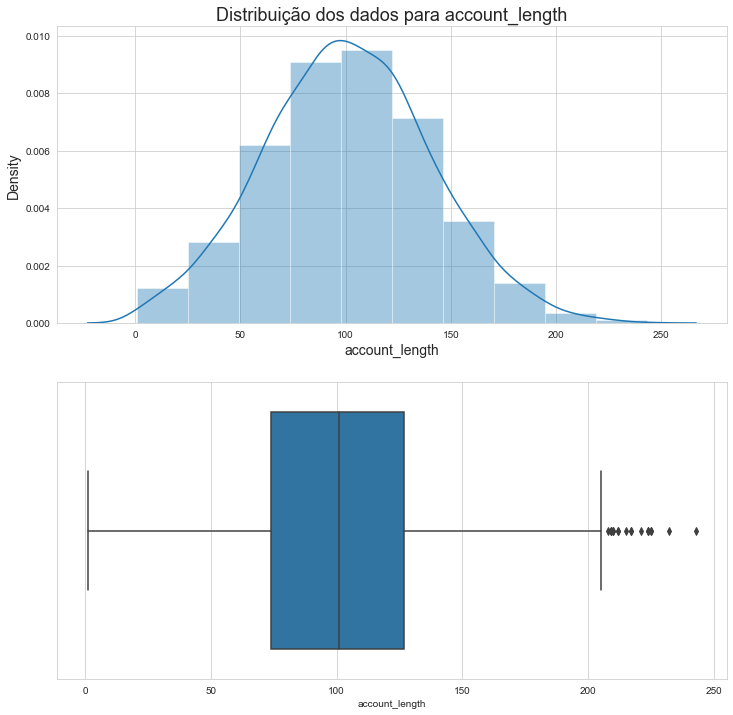

In [29]:
# account_length
find_distribution_outliers("account_length")

**Observation:**
- The data have a normal distribution, that is, they have a mean and median close to each other;
- The variable has outliers above the upper limit; 

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Limites de Outliers para total_day_calls:
Q1 = 87.0
Q3 = 114.0
IQR = 27.0
low_outliers = 46.5
high_outliers = 154.5


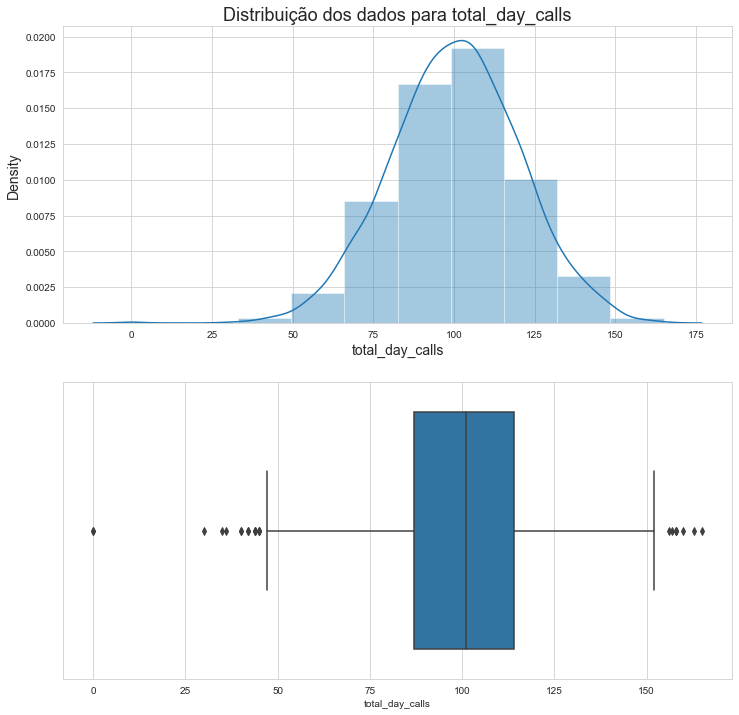

In [30]:
# total_day_calls

find_distribution_outliers("total_day_calls")

**Observations:**
- Data follow a normal distribution;
- Show outliers below the lower limit and above the upper limit. 

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Limites de Outliers para total_day_minutes:
Q1 = 143.7
Q3 = 216.4
IQR = 72.70000000000002
low_outliers = 34.64999999999996
high_outliers = 325.45000000000005


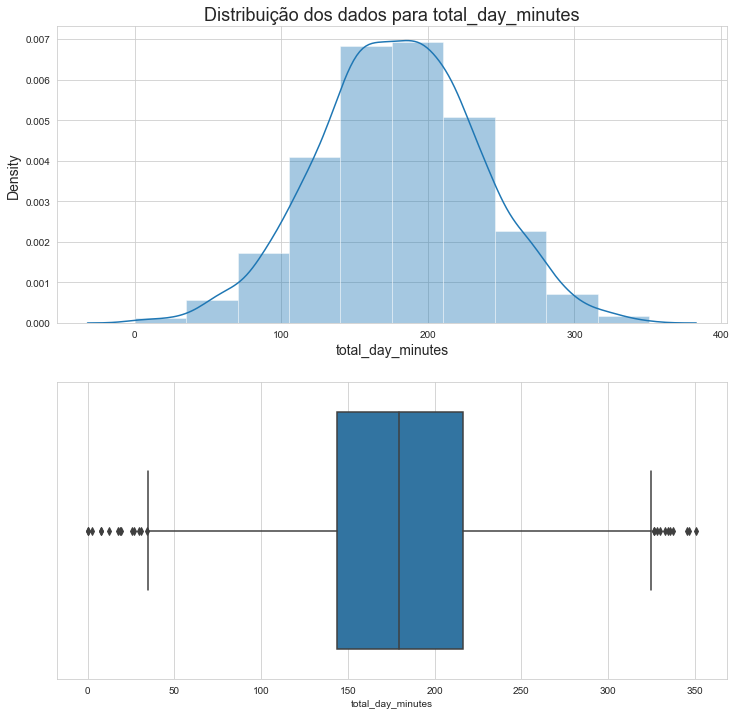

In [31]:
# total_day_minutes

find_distribution_outliers("total_day_minutes")

**Observations:**
- Data follow a normal distribution trend;
- Show outliers below the lower limit and above the upper limit. 

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Limites de Outliers para total_day_charge:
Q1 = 24.43
Q3 = 36.79
IQR = 12.36
low_outliers = 5.890000000000001
high_outliers = 55.33


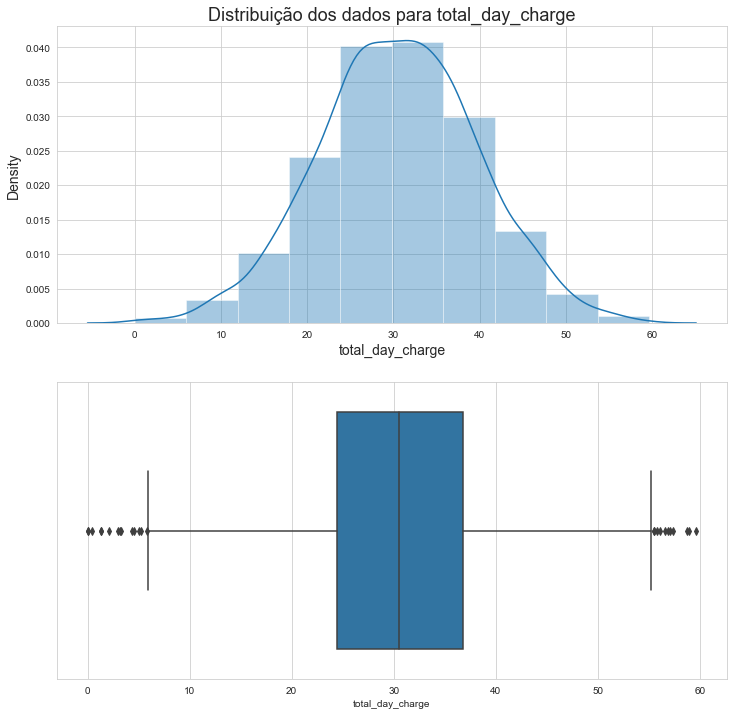

In [32]:
# total_day_charge

find_distribution_outliers("total_day_charge")

**Observations:**
- Data follow a normal distribution trend;
- Show outliers below the lower limit and above the upper limit. 

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Limites de Outliers para total_eve_calls:
Q1 = 87.0
Q3 = 114.0
IQR = 27.0
low_outliers = 46.5
high_outliers = 154.5


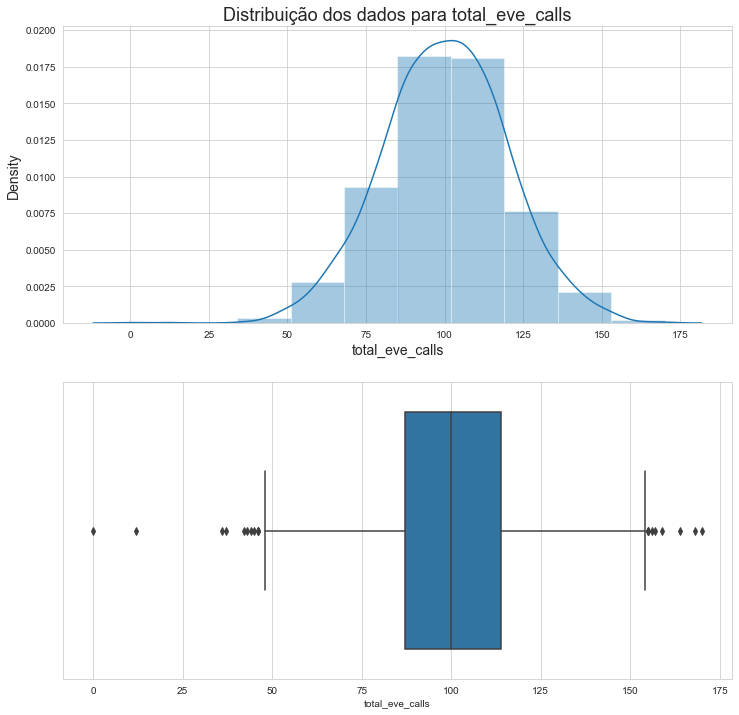

In [33]:
# total_eve_calls

find_distribution_outliers("total_eve_calls")

**Observations:**
- Data follow a normal distribution;
- Show outliers below the lower limit and above the upper limit. 


C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Limites de Outliers para total_eve_minutes:
Q1 = 166.6
Q3 = 235.3
IQR = 68.70000000000002
low_outliers = 63.54999999999997
high_outliers = 338.35


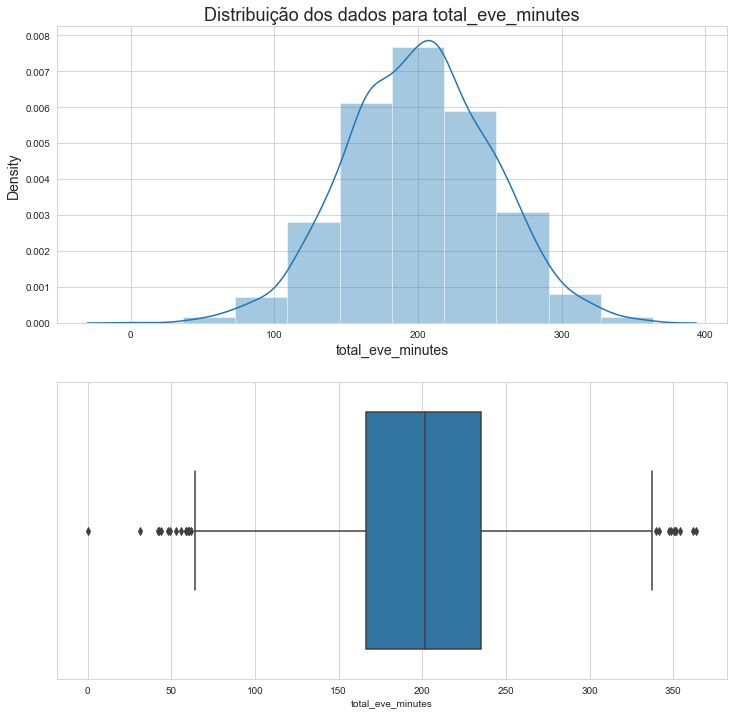

In [34]:
# total_eve_minutes

find_distribution_outliers("total_eve_minutes")

**Observations:**
- Data follow a normal distribution trend;
- Show outliers below the lower limit and above the upper limit. 

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Limites de Outliers para total_eve_charge:
Q1 = 14.16
Q3 = 20.0
IQR = 5.84
low_outliers = 5.4
high_outliers = 28.759999999999998


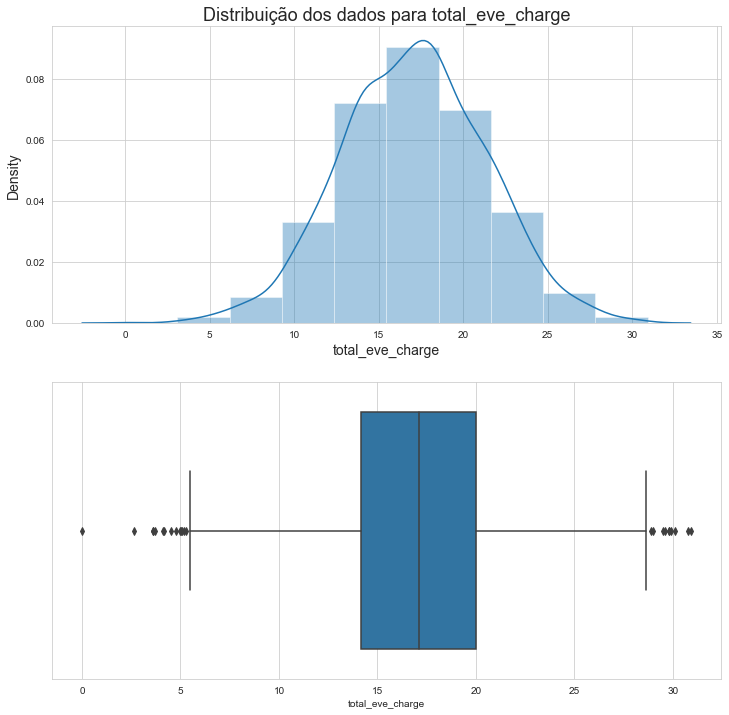

In [35]:
# total_eve_charge

find_distribution_outliers("total_eve_charge")

**Observations:**
- Data follow a normal distribution trend;
- Show outliers below the lower limit and above the upper limit. 

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Limites de Outliers para total_night_calls:
Q1 = 87.0
Q3 = 113.0
IQR = 26.0
low_outliers = 48.0
high_outliers = 152.0


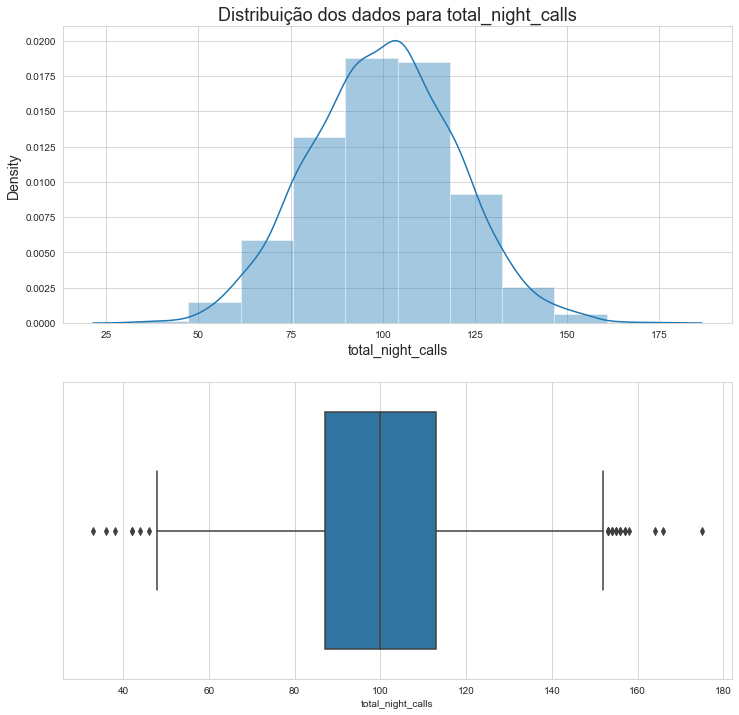

In [36]:
# total_night_calls

find_distribution_outliers("total_night_calls")

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Limites de Outliers para total_night_minutes:
Q1 = 167.0
Q3 = 235.3
IQR = 68.30000000000001
low_outliers = 64.54999999999998
high_outliers = 337.75


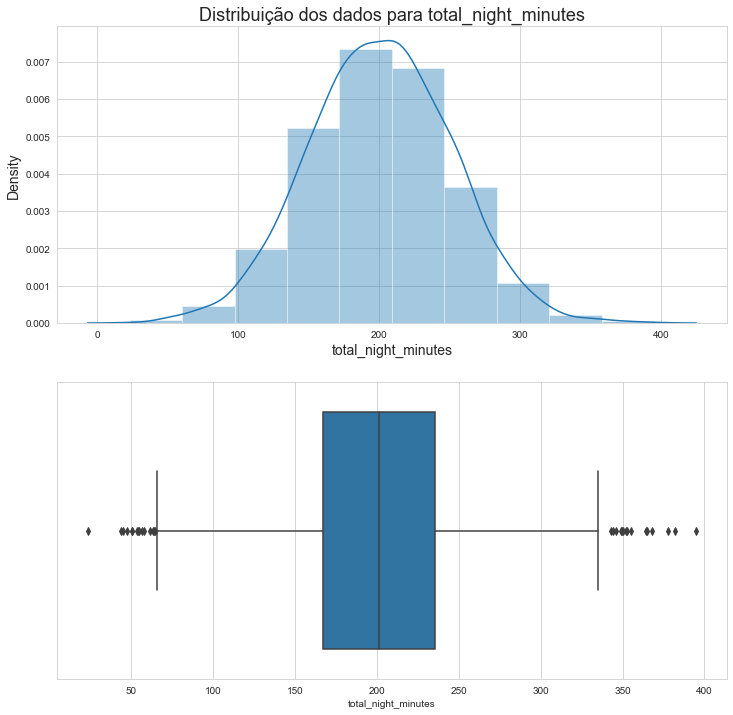

In [37]:
# total_night_minutes

find_distribution_outliers("total_night_minutes")

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Limites de Outliers para total_night_charge:
Q1 = 7.52
Q3 = 10.59
IQR = 3.0700000000000003
low_outliers = 2.914999999999999
high_outliers = 15.195


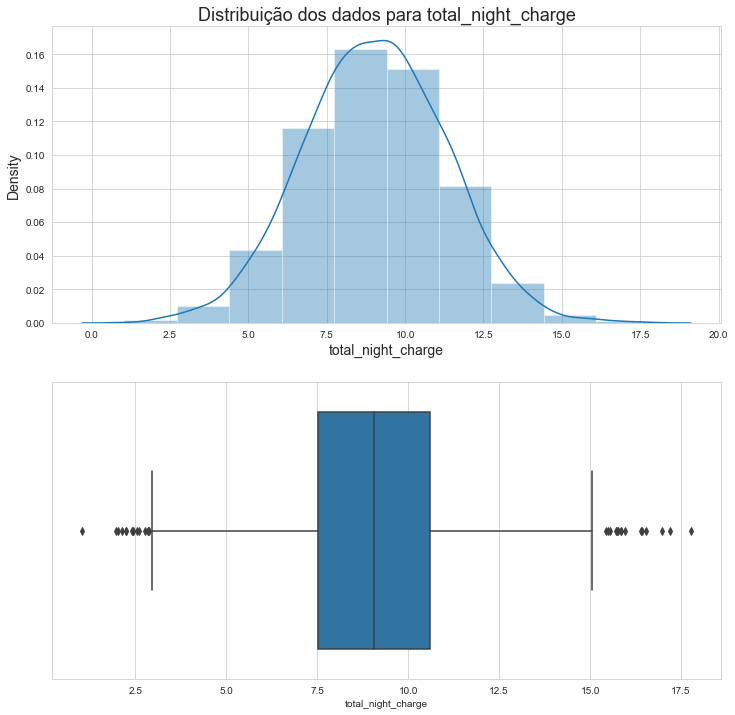

In [38]:
# total_night_charge

find_distribution_outliers("total_night_charge")

**Observations:**
- Data follow a normal distribution;
- Feature lower and upper outliers. 

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Limites de Outliers para total_intl_calls:
Q1 = 3.0
Q3 = 6.0
IQR = 3.0
low_outliers = -1.5
high_outliers = 10.5


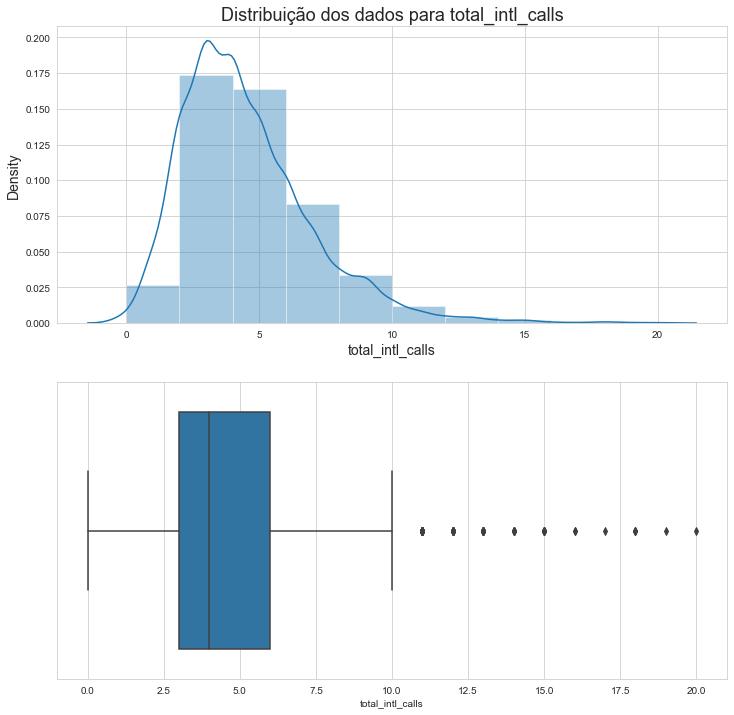

In [39]:
# total_intl_calls

find_distribution_outliers("total_intl_calls")

**Observations:**
- Data follow an exponential distribution, that is, most records have lower values, while higher ones have lower frequency;
- Show outliers above the upper limit. 

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Limites de Outliers para total_intl_minutes:
Q1 = 8.5
Q3 = 12.1
IQR = 3.5999999999999996
low_outliers = 3.1000000000000005
high_outliers = 17.5


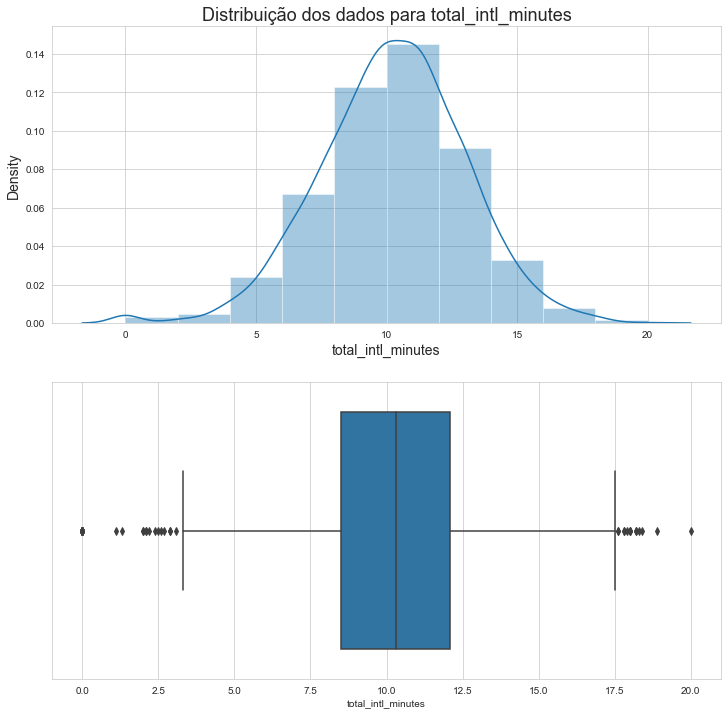

In [40]:
# total_intl_minutes

find_distribution_outliers("total_intl_minutes")

**Observations:**
- Data follow a normal distribution;
- Show outliers below the lower limit and above the upper limit. 

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Limites de Outliers para total_intl_charge:
Q1 = 2.3
Q3 = 3.27
IQR = 0.9700000000000002
low_outliers = 0.8449999999999995
high_outliers = 4.7250000000000005


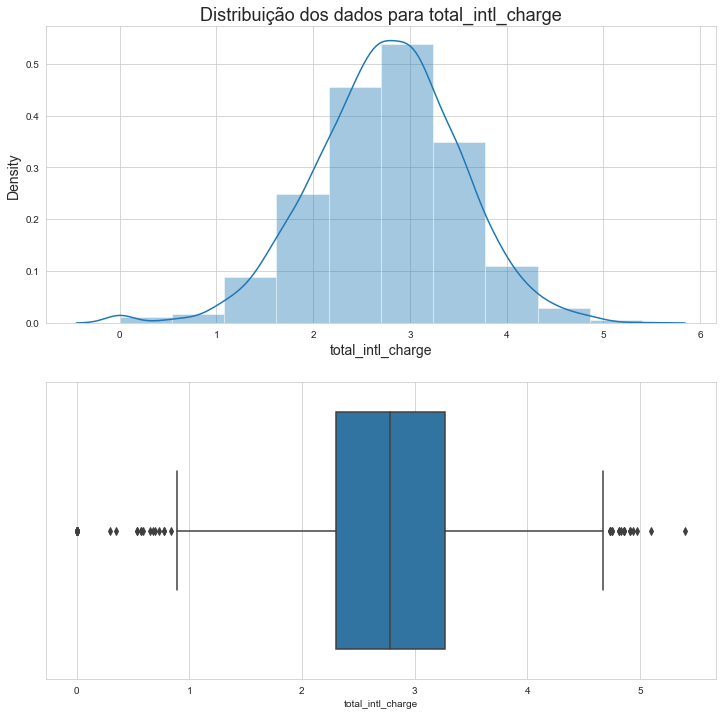

In [41]:
# total_intl_charge

find_distribution_outliers("total_intl_charge")

**Observations:**
- Data follow a normal distribution;
- Show outliers below the lower limit and above the upper limit. 

## 2.4.2 Categorical Variables

In [42]:
train_df_pandas[categorical_var].nunique()

churn                  2
international_plan     2
state                 51
voice_mail_plan        2
dtype: int64

Here we can see that **churn, international_plan and voice_mail_plan** are binary categories, that is, they only have yes or no. The **state** variable has 51 different values, one for each US state. 

In [43]:
categorical_var

['churn', 'international_plan', 'state', 'voice_mail_plan']

In [44]:
numerical_var

['account_length',
 'area_code',
 'id_num',
 'number_customer_service_calls',
 'number_vmail_messages',
 'total_day_calls',
 'total_day_charge',
 'total_day_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_eve_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'total_intl_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_night_minutes']

In [45]:
df1 = train_df_pandas[["state", "number_customer_service_calls"]].groupby("state")["number_customer_service_calls"].sum().reset_index()
df1 = df1.sort_values("number_customer_service_calls", ascending = False)


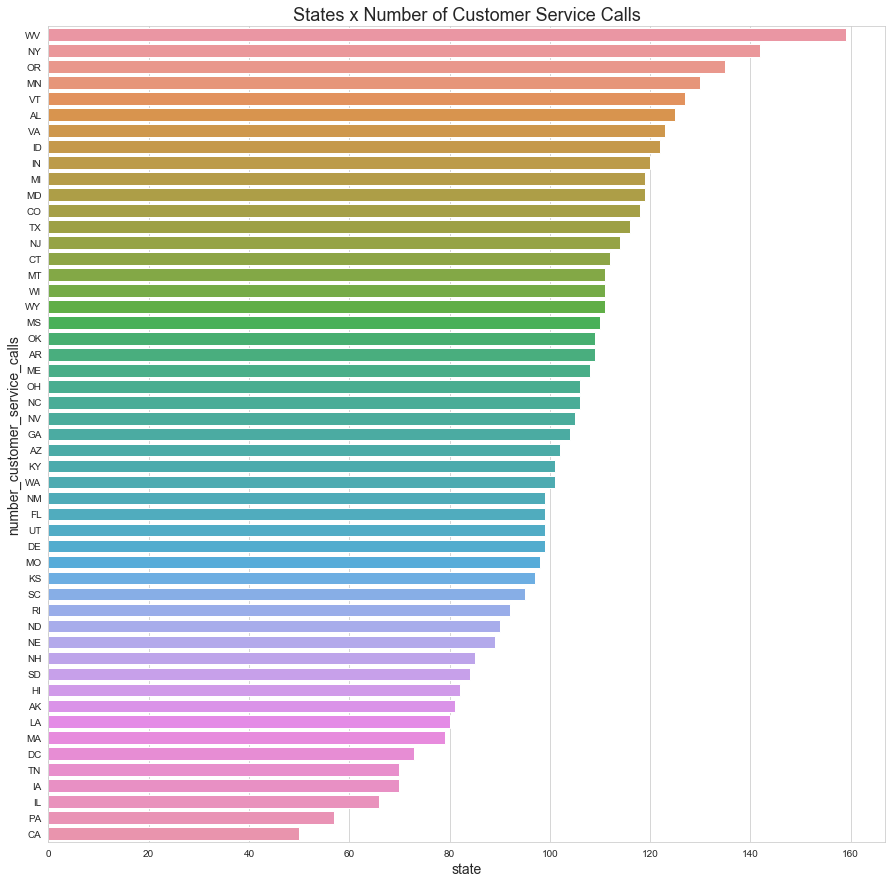

In [46]:
plt.figure(1, figsize=(15,15))
ax = sns.barplot(x = 'number_customer_service_calls', y = 'state', data=df1, orient = "h")
set_plots_features(ax, 'States x Number of Customer Service Calls', 'state', 'number_customer_service_calls')

**Observations:**
- The states that have the most connection to the call center service are WV, NY, OR, MN, VT. 

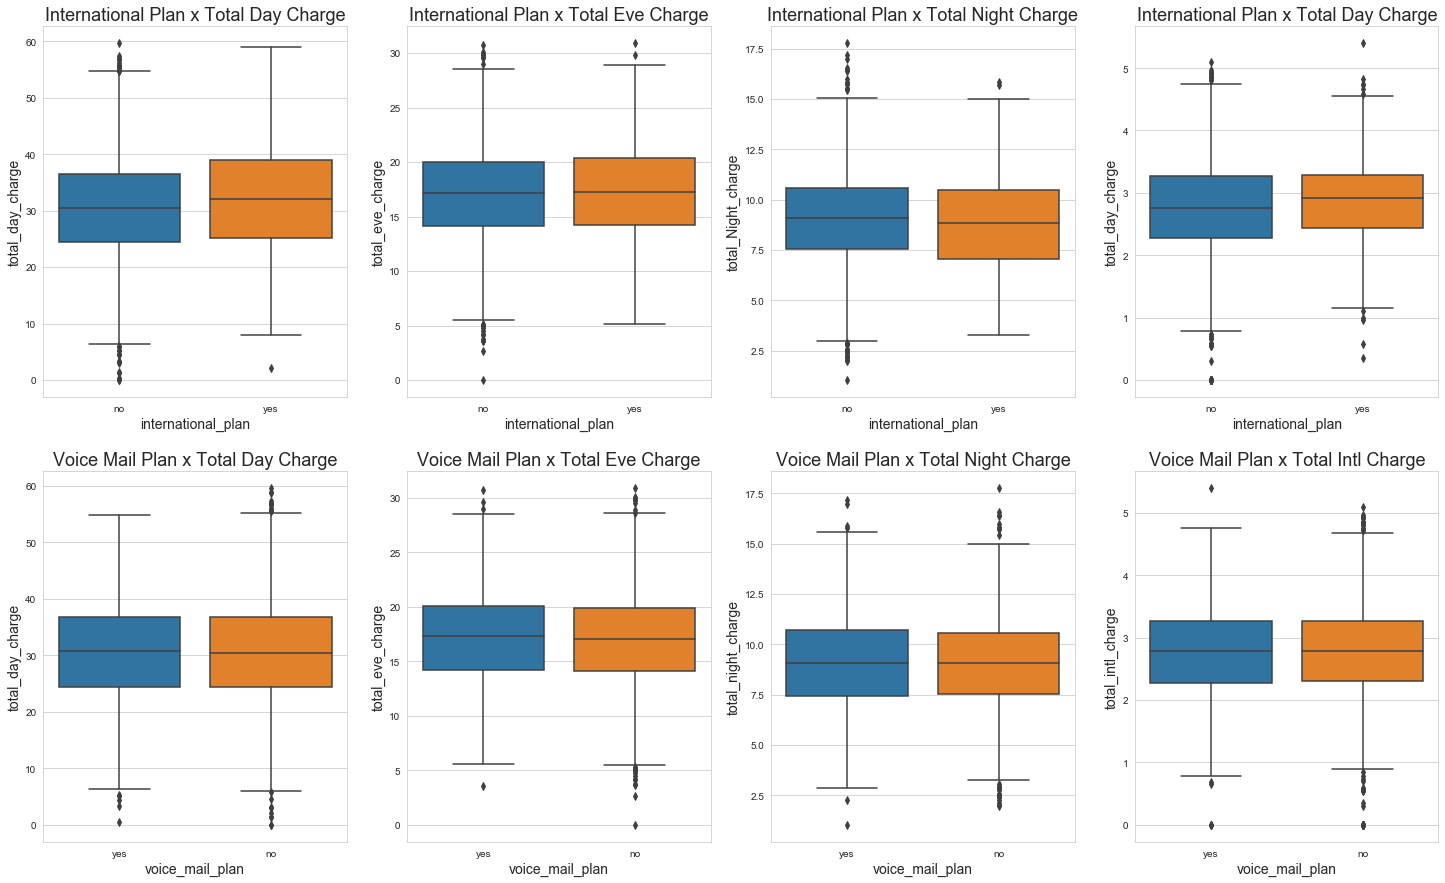

In [47]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(25,15)

plt.subplot(2,4,1)
ax = sns.boxplot(x = 'international_plan', y = 'total_day_charge', data=train_df_pandas)
set_plots_features(ax, 'International Plan x Total Day Charge', 'international_plan', 'total_day_charge')


plt.subplot(2,4,2)
ax = sns.boxplot(x = 'international_plan', y = 'total_eve_charge', data=train_df_pandas)
set_plots_features(ax, 'International Plan x Total Eve Charge', 'international_plan', 'total_eve_charge')


plt.subplot(2,4,3)
ax = sns.boxplot(x = 'international_plan', y = 'total_night_charge', data=train_df_pandas)
set_plots_features(ax, 'International Plan x Total Night Charge', 'international_plan', 'total_Night_charge')


plt.subplot(2,4,4)
ax = sns.boxplot(x = 'international_plan', y = 'total_intl_charge', data=train_df_pandas)
set_plots_features(ax, 'International Plan x Total Day Charge', 'international_plan', 'total_day_charge')



plt.subplot(2,4,5)
ax = sns.boxplot(x = 'voice_mail_plan', y = 'total_day_charge', data=train_df_pandas)
set_plots_features(ax, 'Voice Mail Plan x Total Day Charge', 'voice_mail_plan', 'total_day_charge')


plt.subplot(2,4,6)
ax = sns.boxplot(x = 'voice_mail_plan', y = 'total_eve_charge', data=train_df_pandas)
set_plots_features(ax, 'Voice Mail Plan x Total Eve Charge', 'voice_mail_plan', 'total_eve_charge')


plt.subplot(2,4,7)
ax = sns.boxplot(x = 'voice_mail_plan', y = 'total_night_charge', data=train_df_pandas)
set_plots_features(ax, 'Voice Mail Plan x Total Night Charge', 'voice_mail_plan', 'total_night_charge')


plt.subplot(2,4,8)
ax = sns.boxplot(x = 'voice_mail_plan', y = 'total_intl_charge', data=train_df_pandas)
set_plots_features(ax, 'Voice Mail Plan x Total Intl Charge', 'voice_mail_plan', 'total_intl_charge')



**Observations:**

- The international plan category adds very little to call charges;
- The category of owns a voicemail plan has no influence on the price of charges. 

## 3.0 Mapa de Hipóteses

![Mental_Map](images/mental_map_n.PNG)

To create the hypotheses, a mental map was created, using the variable target **churn** as a central filter and the other features are evaluated as characteristics that can lead to a customer leaving the telephone company. 

## 3.1 Criando Hipóteses

**H1**: Those who have an international plan are at greater risk of abandoning the operator;

**H2**: Whoever has a mailbox has less risk of abandoning the operator;

**H3**: States with more immigrants are more at risk of abandoning the operator;

**H4:** Customers with higher churn risk speak less than those with less risk, on average;

**H5**: Customers over 100 days have less risk of abandoning the operator;

**H6**: People who are in churn have a higher minute price than those who are not;

**H7**: Those who have an international plan and use little have a greater chance of abandoning the operator;

**H8**: Those who have an international plan pay less than those who do not, and consequently, have a lower risk of leaving the operator;

**H9**: Those who call the call center more often have more churn risks. 

**H10**: Customers with a profile of talking longer during the day are more likely to leave the operator;

**H11**: The price per minute during the day is more expensive than at night and at dawn;

**H12**: Clients who are on churn spend more during the day than at night and at dawn. 

## 4.0 Feature Engineering

In the feature engineering step, we'll create variables capable of helping in the exploratory data analysis, grouping some features and adding others to get the total for the entire day. This step is very important not only to generate insights into the business problem, but also to find the characteristics needed for the model to make the best decisions. 

### 4.0.1 Total calls during 24h

In [48]:
train_df_pandas["total_calls"] = train_df_pandas["total_day_calls"] + train_df_pandas["total_eve_calls"] + train_df_pandas["total_night_calls"] 

### 4.0.2 Total minutes spoken during 24h

In [49]:
train_df_pandas["total_minutes"] = train_df_pandas["total_day_minutes"] + train_df_pandas["total_eve_minutes"] + train_df_pandas["total_night_minutes"] 

### 4.0.3 Costs of calls during 24h

In [50]:
train_df_pandas["total_charge"] = train_df_pandas["total_day_charge"] + train_df_pandas["total_eve_charge"] + train_df_pandas["total_night_charge"] 

### 4.0.4 Minute Cost

In [51]:
train_df_pandas["minute_price"] = train_df_pandas["total_charge"] / train_df_pandas["total_minutes"] # Quanto ela gasta por minuto

### 4.0.5 Call Minutes

In [52]:
train_df_pandas["minutes_calls"] = train_df_pandas["total_minutes"] / train_df_pandas["total_calls"] # Quanto ela fala por chamada

### 4.0.6 Minutes by international calls

In [53]:
train_df_pandas["intl_calls_minutes"] = train_df_pandas["total_intl_minutes"] / train_df_pandas["total_intl_calls"] # Quanto ela fala por chamada internacional

### 4.0.7 Minute price in a international call

In [54]:
train_df_pandas["intl_minute_price"] = train_df_pandas["total_intl_charge"] / train_df_pandas["total_intl_minutes"] # Quanto ela gasta por minuto

### 4.0.8 Minute by call during a day

In [55]:
train_df_pandas["minute_price_day"] = train_df_pandas["total_day_charge"] / train_df_pandas["total_day_minutes"] # Quanto ela gasta por minuto

### 4.0.9 Minute by call during a night

In [56]:
train_df_pandas["minute_price_eve"] = train_df_pandas["total_eve_charge"] / train_df_pandas["total_eve_minutes"] # Quanto ela gasta por minuto

### 4.0.10 Minute by call during a dawn

In [57]:
train_df_pandas["minute_price_night"] = train_df_pandas["total_night_charge"] / train_df_pandas["total_night_minutes"] # Quanto ela gasta por minuto

### 4.0.8 Whether or not you reside in a top5 state with the highest number of immigrants in the US 

In [58]:
top5_foreign_states = ["CA", "NY", "NJ", "FL", "NV"]

train_df_pandas["is_top5_foreign_state"] = train_df_pandas["state"].apply(lambda state: "yes" if state in top5_foreign_states else "no")

## 4.1 Variables Filtering

Several numerical variables have a very large number of outliers, as shown in section **2.4.1.2**. Thus, we restrict the range of values in order to filter these variables and reduce the chance that they have some type of measurement error, which is the cause of many outliers. To make the changes, a PySpark DataFrame is used again. 

In [59]:
# Convert to spark dataframe
trainDF2 = spark.createDataFrame(train_df_pandas)

In [60]:
# Upper filter for the account length variable due to upper outliers 
trainDF2 = trainDF2.filter(trainDF2.account_length < 210)

In [61]:
# Upper filter for total_day_calls variable due to upper and lower outliers 
trainDF2 = trainDF2.filter(trainDF2.total_day_calls > 46).filter(trainDF2.total_day_calls < 160)

In [62]:
# Upper filter for total_day_minutes variable due to upper and lower outliers 
trainDF2 = trainDF2.filter(trainDF2.total_day_minutes > 35).filter(trainDF2.total_day_minutes < 330)

In [63]:
# Upper filter for total_day_charge variable due to upper and lower outliers 
trainDF2 = trainDF2.filter(trainDF2.total_day_charge > 5.5).filter(trainDF2.total_day_charge < 60)

In [64]:
# Upper filter for total_eve_calls variable due to upper and lower outliers 
trainDF2 = trainDF2.filter(trainDF2.total_eve_calls > 46).filter(trainDF2.total_eve_calls < 160)

In [65]:
# Upper filter for total_eve_minutes variable due to upper and lower outliers 
trainDF2 = trainDF2.filter(trainDF2.total_eve_minutes > 65).filter(trainDF2.total_eve_minutes < 340)

In [66]:
# Top filter for total_eve_charge variable due to upper and lower outliers 
trainDF2 = trainDF2.filter(trainDF2.total_eve_charge > 5).filter(trainDF2.total_eve_charge < 30)

In [67]:
# Upper filter for total_night_calls variable due to upper and lower outliers 
trainDF2 = trainDF2.filter(trainDF2.total_night_calls > 48).filter(trainDF2.total_night_calls < 160)

In [68]:
# Upper filter for total_night_minutes variable due to upper and lower outliers 
trainDF2 = trainDF2.filter(trainDF2.total_night_minutes > 64).filter(trainDF2.total_night_minutes < 340)

In [69]:
# Upper filter for the total night charge variable due to upper and lower outliers 
trainDF2 = trainDF2.filter(trainDF2.total_night_charge > 3).filter(trainDF2.total_night_charge < 16)

In [70]:
# Upper filter for total_intl_calls variable due to upper outliers 
trainDF2 = trainDF2.filter(trainDF2.total_intl_calls < 12)

In [71]:
# Upper filter for total_intl_minutes variable due to upper and lower outliers 
trainDF2 = trainDF2.filter(trainDF2.total_intl_minutes > 3).filter(trainDF2.total_intl_minutes < 17.5)

In [72]:
# Upper filter for total_intl_charge variable due to upper and lower outliers 
trainDF2 = trainDF2.filter(trainDF2.total_intl_charge > 0.8).filter(trainDF2.total_intl_charge < 4.7)

### 4.3 Size of new dataset

In [73]:
print("Train data dimension: ({row}, {column})".format(row = trainDF2.count(), column = len(trainDF2.columns)))

Train data dimension: (3106, 32)


## 5.0 Exploratory Data Analysis

In the exploratory data analysis stage, we seek to find which variables are most important to the model, the relationships of each with the target variable and also between features. In addition, it is at this stage that value is added to the business, through the validation of hypotheses created in section **3.1**. 

EDA is divided into 3 stages: univariate, bivariate and multivariate. 

In [74]:
# Again, let's convert a spark dataframe to pandas dataframe to make it easier to analyze
train_df_pandas2 = trainDF2.toPandas()

In [75]:
train_df_pandas2.head()

,account_length,area_code,churn,id_num,international_plan,number_customer_service_calls,number_vmail_messages,state,total_day_calls,total_day_charge,total_day_minutes,total_eve_calls,total_eve_charge,total_eve_minutes,total_intl_calls,total_intl_charge,total_intl_minutes,total_night_calls,total_night_charge,total_night_minutes,voice_mail_plan,total_calls,total_minutes,total_charge,minute_price,minutes_calls,intl_calls_minutes,intl_minute_price,minute_price_day,minute_price_eve,minute_price_night,is_top5_foreign_state
0,128,415,no,1,no,1,25,KS,110,45.07,265.1,99,16.78,197.4,3,2.70,10.0,91,11.01,244.7,yes,300,707.2,72.86,0.103026,2.357333,3.333333,0.270000,0.170011,0.085005,0.044994,no
1,107,415,no,2,no,1,26,OH,123,27.47,161.6,103,16.62,195.5,3,3.70,13.7,103,11.45,254.4,yes,329,611.5,55.54,0.090826,1.858663,4.566667,0.270073,0.169988,0.085013,0.045008,no
2,137,415,no,3,no,0,0,NJ,114,41.38,243.4,110,10.30,121.2,5,3.29,12.2,104,7.32,162.6,no,328,527.2,59.00,0.111912,1.607317,2.440000,0.269672,0.170008,0.084983,0.045018,yes
3,75,415,no,5,yes,3,0,OK,113,28.34,166.7,122,12.61,148.3,3,2.73,10.1,121,8.41,186.9,no,356,501.9,49.36,0.098346,1.409831,3.366667,0.270297,0.170006,0.085030,0.044997,no
4,118,510,no,6,yes,0,0,AL,98,37.98,223.4,101,18.75,220.6,6,1.70,6.3,118,9.18,203.9,no,317,647.9,65.91,0.101729,2.043849,1.050000,0.269841,0.170009,0.084995,0.045022,no


### 5.1 Univariate Analysis

### 5.1.1 Target Variable

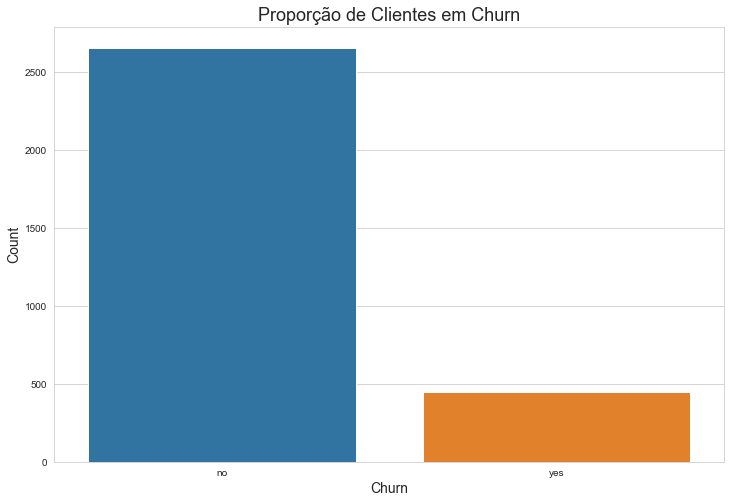

In [76]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(12,8)


ax = sns.countplot(x = 'churn', data = train_df_pandas2)
set_plots_features(ax, "Proporção de Clientes em Churn", "Churn", "Count")

In [77]:
train_df_pandas2["churn"].value_counts(normalize = True)

no     0.856085
yes    0.143915
Name: churn, dtype: float64

**Observation**:
Churn rate in training data reaches 14.39%, which is considered much higher than a normal rate, which is close to 5% in a healthy company. 

### 5.1.2 Numerical Variables

In [78]:
numerical_var.remove("id_num")

C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B7C4693A20>,
      dtype=object)

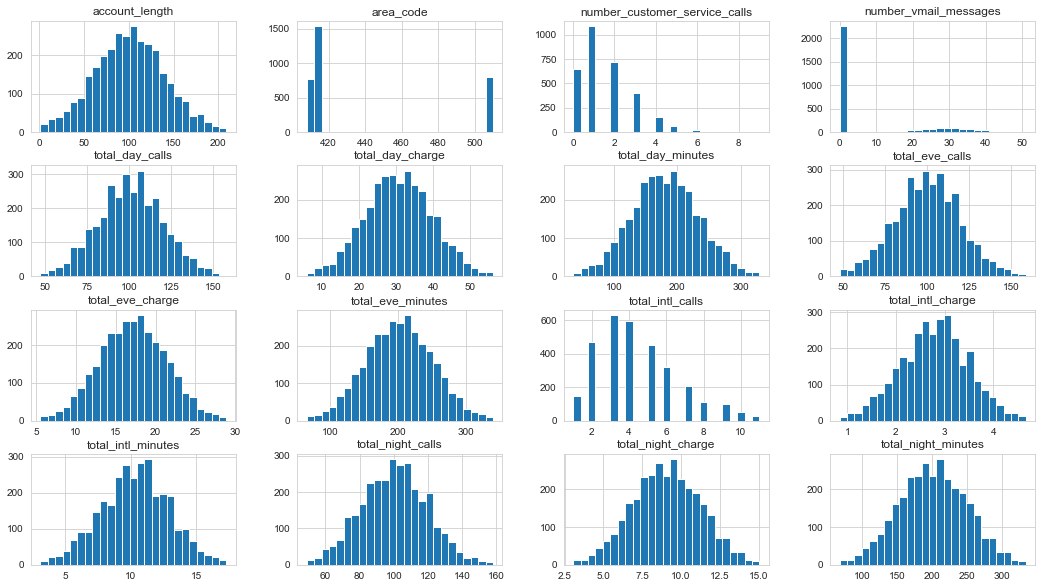

In [79]:
fig = plt.figure(figsize=(18,10))

ax = fig.gca()
    
train_df_pandas2[numerical_var].hist(ax = ax, bins = 25)

**Observations:**

- It is possible to observe that most of the operator's users are customers within a period between 50 and 150 days;
- The largest number of complaints in the call center is 1 call, however, there are still many users with 2 or more calls;
- The concentration of messages in voicemail is below 10, however, there are some users between 20 and 40 messages;
- Call data have a distribution very close to normal, with the exception of international calls which tend to be an exponential distribution. 

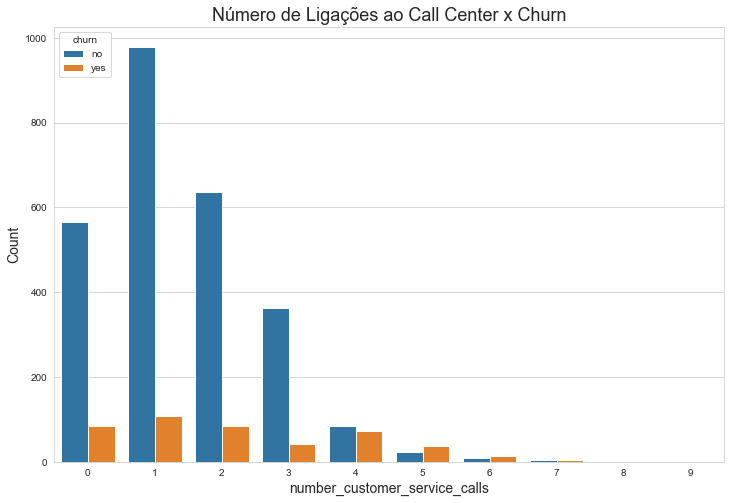

In [80]:
fig = plt.figure(figsize=(12,8))

ax = fig.gca()

ax = sns.countplot(x="number_customer_service_calls", hue = "churn", data = train_df_pandas2)
set_plots_features(ax, "Número de Ligações ao Call Center x Churn", "number_customer_service_calls", "Count")

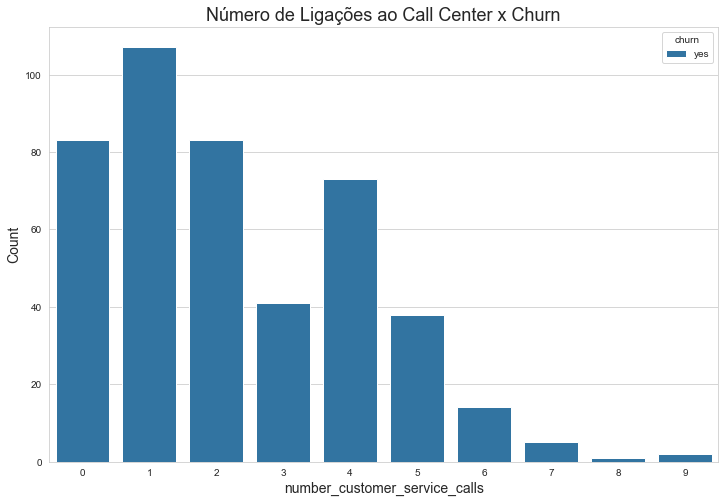

In [81]:
df_aux = train_df_pandas2[train_df_pandas2["churn"] == "yes"]

fig = plt.figure(figsize=(12,8))

ax = fig.gca()

ax = sns.countplot(x="number_customer_service_calls", hue = "churn", data = df_aux)
set_plots_features(ax, "Número de Ligações ao Call Center x Churn", "number_customer_service_calls", "Count")

**Observação**:ustomers who are not in Churn complain on average 2x, while the number of complaints from those in Churn does not show a stable average, since there is a good number of complaints in 1 or 2x, however, there is another peak at 4x. 

### 5.1.3 Categorical Variables

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\joaop\anaconda3\lib\site-

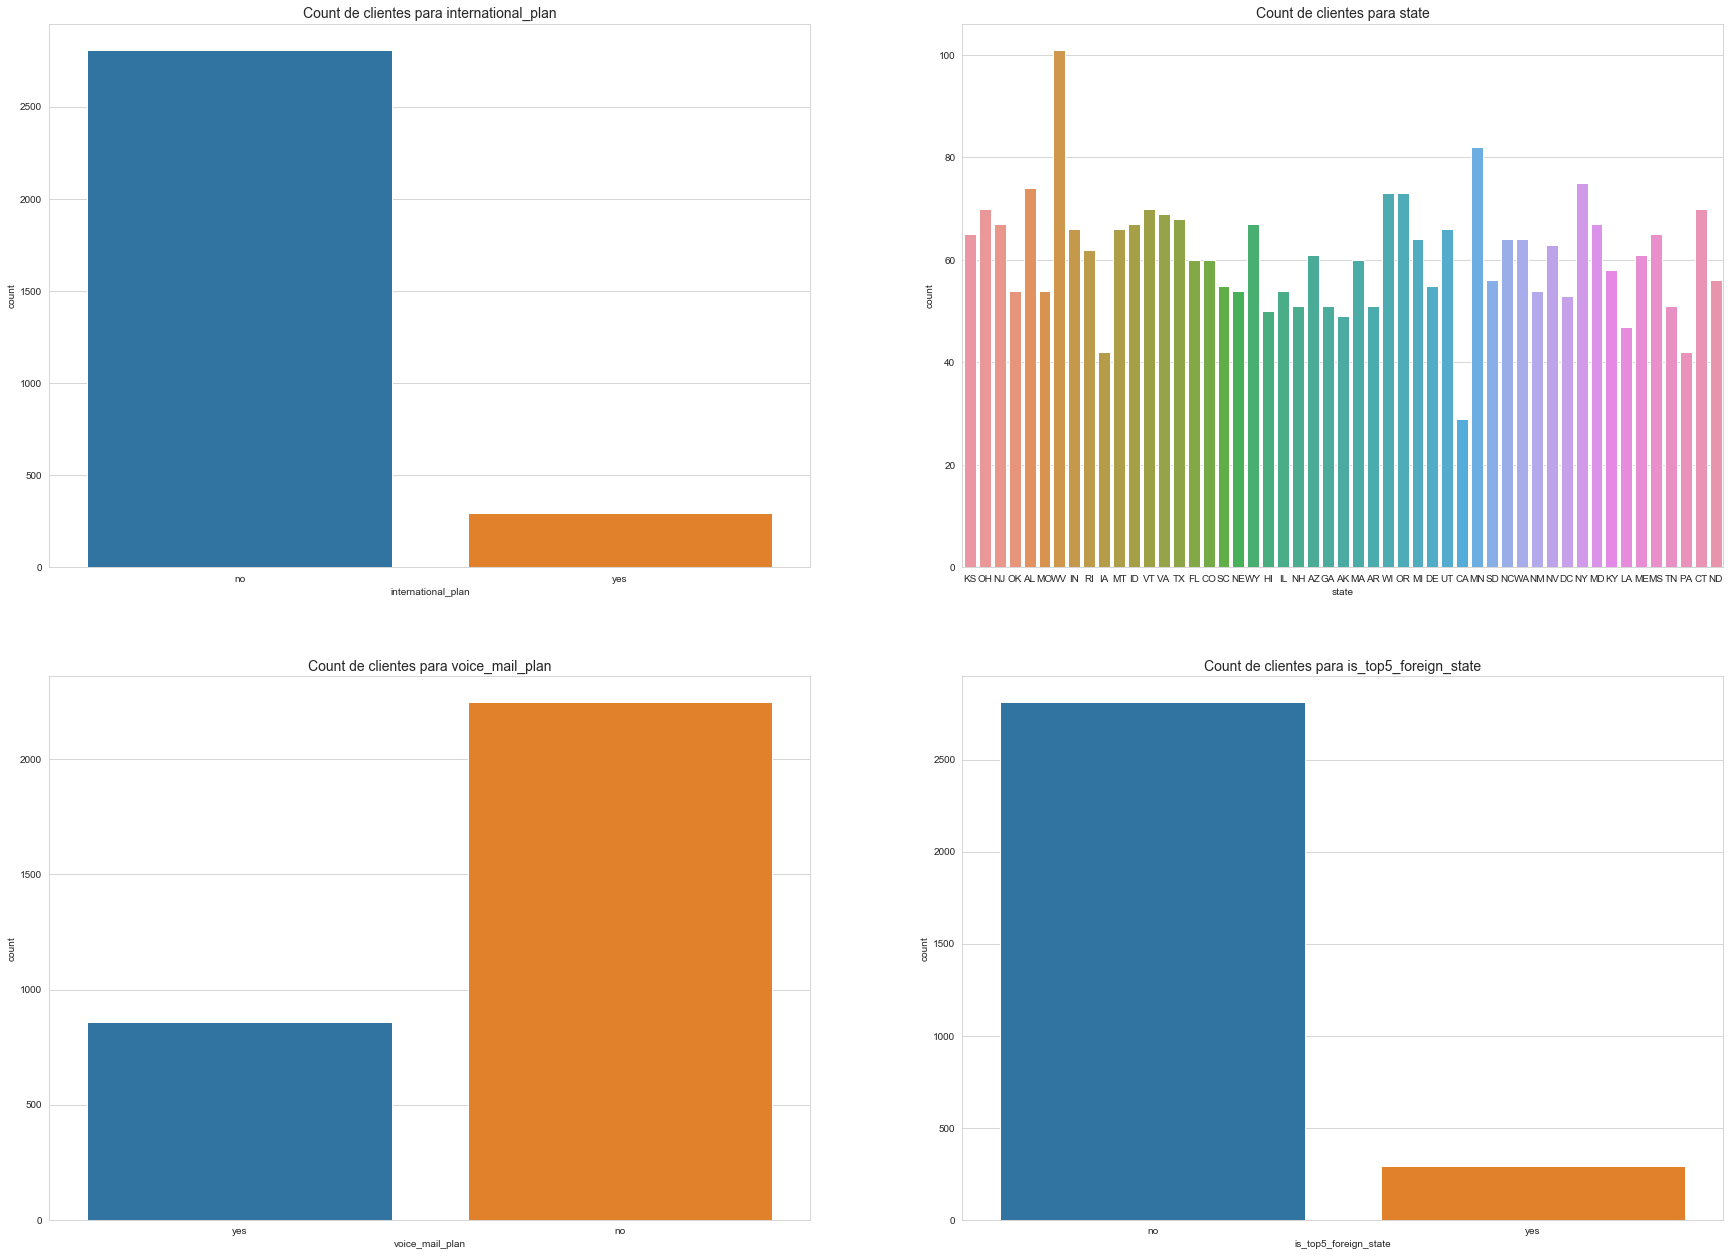

In [82]:
# sets plot size
plt.figure(figsize=(30,22))

# sets the initial plot position
n = 1

for cat in categorical_var[1:] + ["is_top5_foreign_state"]:
    plt.subplot(2,2,n)
    _ = sns.countplot(train_df_pandas2[cat])
    plt.title("Count de clientes para " + cat, fontsize=14)
    
    n = n+1

**Observation**:

- Most customers do not have an international plan;
- The number of customers per state is considerably distributed;
- Most customers do not have voicemail;
- Most clients do not live in states populated by immigrants. 

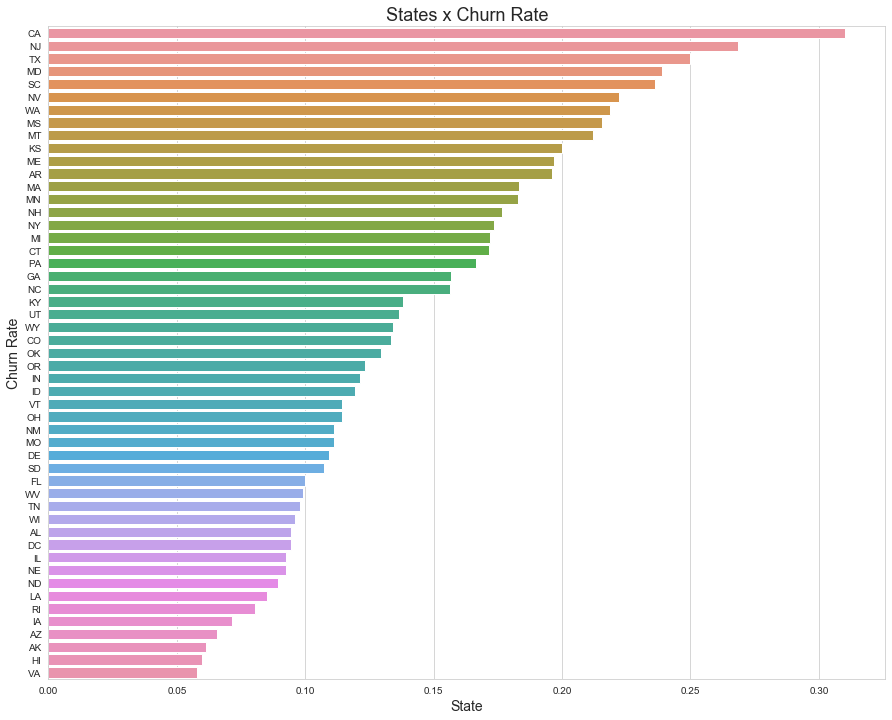

In [83]:
# sets plot size
plt.figure(figsize=(15,12))

df_states = train_df_pandas2.groupby("state")["churn"].value_counts(normalize=True)
churn_state = pd.DataFrame(df_states[df_states.index.isin(['yes'], level=1)]).droplevel(level=1).sort_values("churn", ascending=False)

ax = sns.barplot(x = 'churn', y = churn_state.index, data=churn_state, orient = "h")
set_plots_features(ax, 'States x Churn Rate', 'State', 'Churn Rate')


**Observations:**

- Most customers do not have an international plan (only 9.59%);
- The operator has more customers in West Virginia (3.25%), Minnesota (2.64%) and New York (2.41%);
- More than 70% of users do not have voicemail;
- Only 9.46% of users are from states with more US immigrants.
- Many states have a very high Churn Rate, such as California, New Jersey, Texas... 

## 5.2 Bivariate Analysis

It is at this stage of EDA that we respond to the hypotheses generated: 

### 5.2.1 Validating Hypotheses 

**H1:** Those who have an international plan are at greater risk of abandoning the operator;

**TRUTH**: Whoever has an international plan presents more risks to abandon the operator. 

In [84]:
df_aux_int = train_df_pandas2[train_df_pandas2["international_plan"] == "yes"]
df_aux_no_int = train_df_pandas2[train_df_pandas2["international_plan"] == "no"]

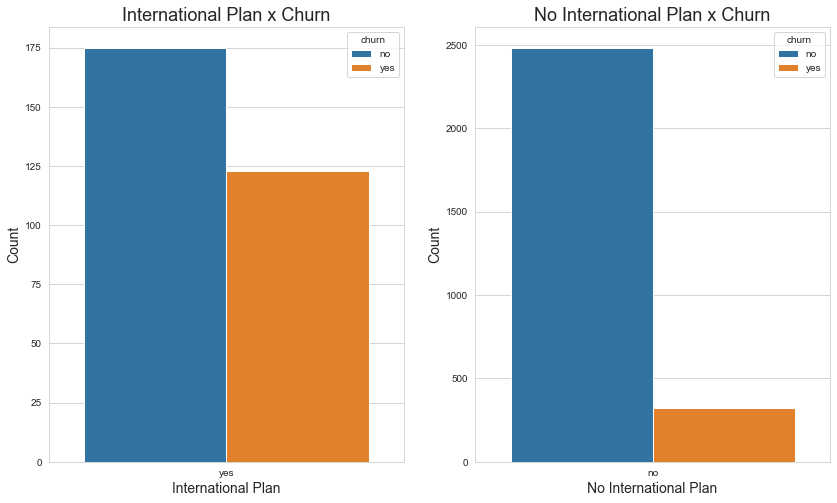

In [85]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.countplot(x = "international_plan", hue = "churn", data = df_aux_int)
set_plots_features(ax, "International Plan x Churn", "International Plan", "Count")

plt.subplot(1,2,2)
ax = sns.countplot(x = "international_plan", hue = "churn", data = df_aux_no_int)
set_plots_features(ax, "No International Plan x Churn", "No International Plan", "Count")

**H2:** Those who have a mailbox have less risk of abandoning the operator;

**TRUTH**: Whoever has a mailbox has less chance of abandoning the operator. 

In [86]:
df_aux_cp = train_df_pandas2[train_df_pandas2["voice_mail_plan"] == "yes"]
df_aux_no_cp = train_df_pandas2[train_df_pandas2["voice_mail_plan"] == "no"]

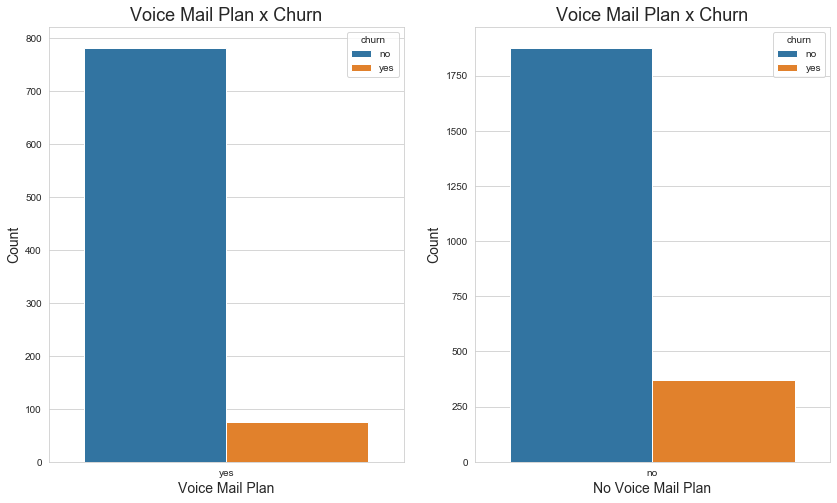

In [87]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.countplot(x = "voice_mail_plan", hue = "churn", data = df_aux_cp)
set_plots_features(ax, "Voice Mail Plan x Churn", "Voice Mail Plan", "Count")

plt.subplot(1,2,2)
ax = sns.countplot(x = "voice_mail_plan", hue = "churn", data = df_aux_no_cp)
set_plots_features(ax, "Voice Mail Plan x Churn", "No Voice Mail Plan", "Count")

**H3:** States with more immigrants are more at risk of abandoning the operator;

**TRUTH**: States with more immigrants tend to have more exits from the operator. 

In [88]:
df_aux_im = train_df_pandas2[train_df_pandas2["is_top5_foreign_state"] == "yes"]
df_aux_no_im = train_df_pandas2[train_df_pandas2["is_top5_foreign_state"] == "no"]

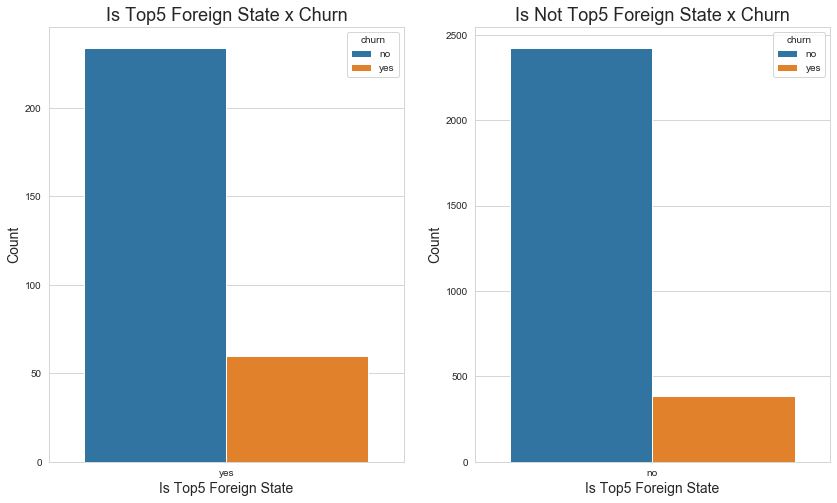

In [89]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.countplot(x = "is_top5_foreign_state", hue = "churn", data = df_aux_im)
set_plots_features(ax, "Is Top5 Foreign State x Churn", "Is Top5 Foreign State", "Count")

plt.subplot(1,2,2)
ax = sns.countplot(x = "is_top5_foreign_state", hue = "churn", data = df_aux_no_im)
set_plots_features(ax, "Is Not Top5 Foreign State x Churn", "Is Top5 Foreign State", "Count")

**H4:** Customers with higher churn risk speak less than those with less risk, on average.

**FALSE**: Churn customers talk more than non-churn customers. 

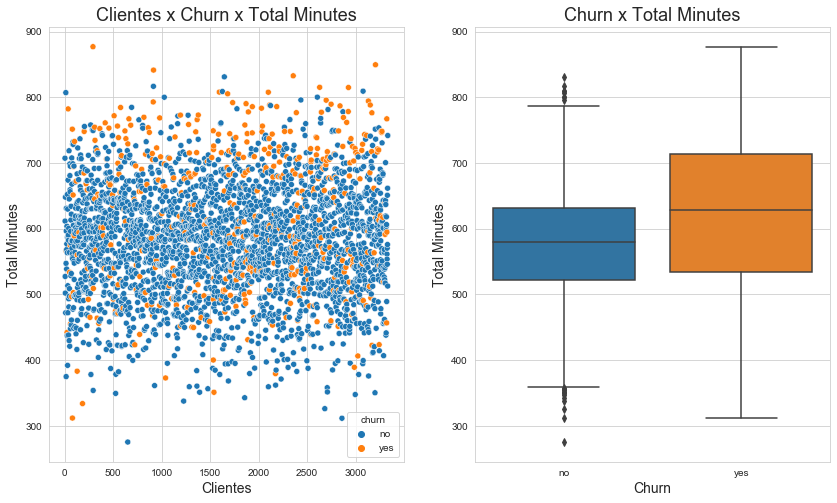

In [90]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(14,8)


plt.subplot(1,2,1)
ax = sns.scatterplot(x = "id_num", hue = 'churn', y = "total_minutes", data = train_df_pandas2)
set_plots_features(ax, "Clientes x Churn x Total Minutes", "Clientes", "Total Minutes")

plt.subplot(1,2,2)
ax = sns.boxplot(x = "churn", y = "total_minutes", data = train_df_pandas2)
set_plots_features(ax, "Churn x Total Minutes", "Churn", "Total Minutes")


**H5**: Customers over 100 days have less risk of abandoning the operator;

**TRUTH**: Customers with an account_length greater than 100 days have less risk of abandoning the operator. 

In [91]:
df_aux_acc = train_df_pandas2[train_df_pandas2["account_length"] > 100]
round(df_aux_acc["churn"].value_counts(normalize=True), 4)*100

no     85.32
yes    14.68
Name: churn, dtype: float64

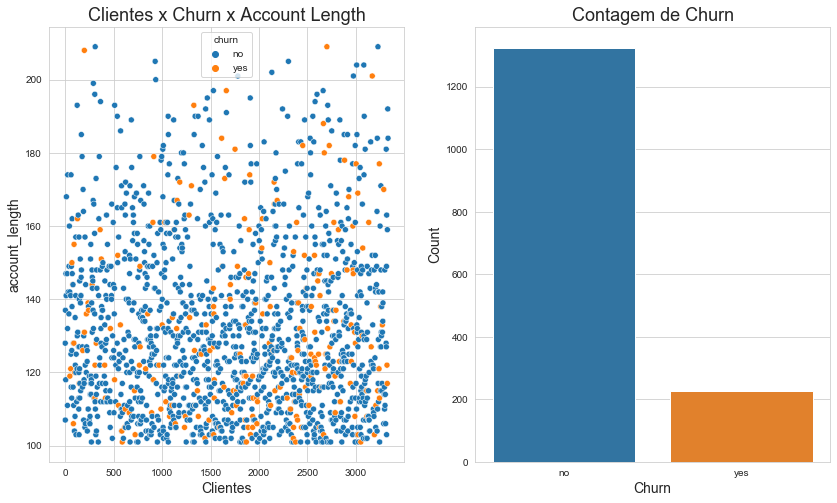

In [92]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)

# Scatter Plot
plt.subplot(1,2,1)
ax = sns.scatterplot(x = 'id_num', hue='churn', y= 'account_length', data=df_aux_acc)
set_plots_features(ax, 'Clientes x Churn x Account Length', 'Clientes', 'account_length')

plt.subplot(1,2,2)
ax = sns.countplot(x = 'churn', data=df_aux_acc)
set_plots_features(ax, 'Contagem de Churn', 'Churn', 'Count')



**H6**: People who are in churn have a higher minute price than those who are not;

**FALSE**: The price per minute for those who are in churn is slightly higher, however, it is not enough to say that it influences the risk. 

In [93]:
df_aux_churn = train_df_pandas2[train_df_pandas2["churn"] == "yes"]
df_aux_no_churn = train_df_pandas2[train_df_pandas2["churn"] == "no"]

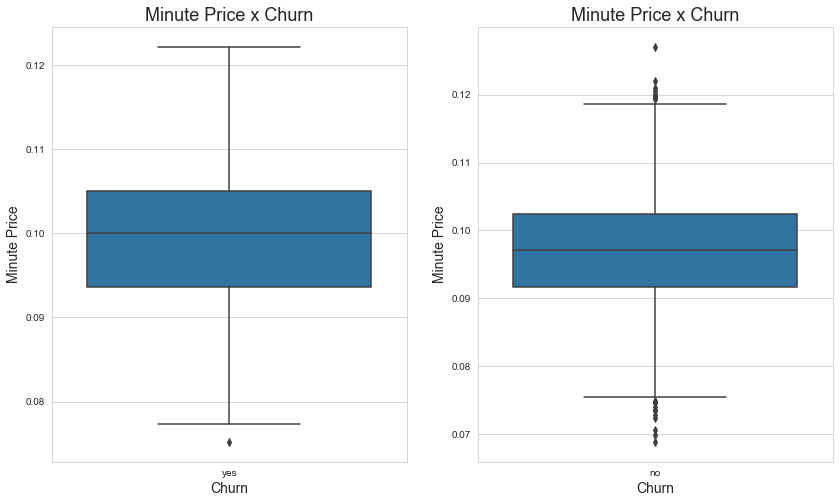

In [94]:
fig, ax = plt.subplots()

ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.boxplot(x = "churn", y = "minute_price", data = df_aux_churn)
set_plots_features(ax, "Minute Price x Churn", "Churn", "Minute Price")

plt.subplot(1,2,2)
ax = sns.boxplot(x = "churn", y = "minute_price", data = df_aux_no_churn)
set_plots_features(ax, "Minute Price x Churn", "Churn", "Minute Price")

**H7**: Those who have an international plan and use little (less than 4 calls) are more likely to leave the operator;

**TRUTH**: Whoever has an international plan and uses it less than 4 times, has almost twice the chance of leaving the operator. 

In [95]:
df_aux_intl = train_df_pandas2[(train_df_pandas2["international_plan"] == "yes") & (train_df_pandas2["total_intl_calls"] < 4)]

In [96]:
round(df_aux_intl["churn"].value_counts(normalize=True),4)*100

yes    60.8
no     39.2
Name: churn, dtype: float64

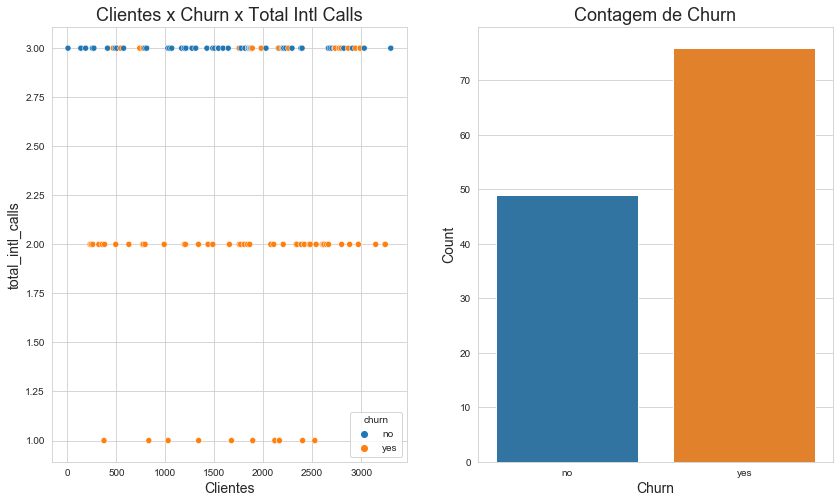

In [97]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)

# Scatter Plot
plt.subplot(1,2,1)
ax = sns.scatterplot(x = 'id_num', hue='churn', y= 'total_intl_calls', data=df_aux_intl)
set_plots_features(ax, 'Clientes x Churn x Total Intl Calls', 'Clientes', 'total_intl_calls')

plt.subplot(1,2,2)
ax = sns.countplot(x = 'churn', data=df_aux_intl)
set_plots_features(ax, 'Contagem de Churn', 'Churn', 'Count')



**H8**: Those who have an international plan pay less than those who do not, and consequently, have a lower risk of leaving the operator;

**FALSE**: Really, whoever has the international plan pays less for the minute of the international call, however, the difference is in a very low order to the point of asserting that this hypothesis is true. 

In [98]:
df_aux_intl = train_df_pandas2[(train_df_pandas2["international_plan"] == "yes")]

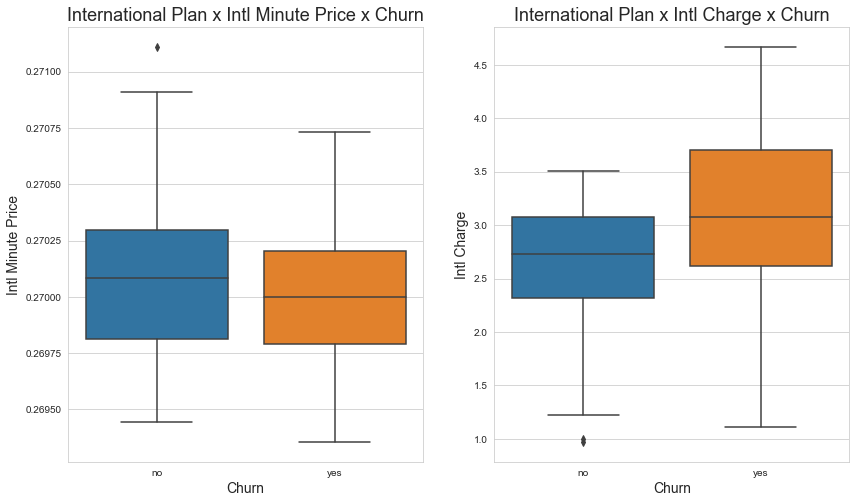

In [99]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.boxplot(x = "churn", y = "intl_minute_price", data = df_aux_intl)
set_plots_features(ax, "International Plan x Intl Minute Price x Churn", "Churn", "Intl Minute Price")

plt.subplot(1,2,2)
ax = sns.boxplot(x = "churn", y = "total_intl_charge", data = df_aux_intl)
set_plots_features(ax, "International Plan x Intl Charge x Churn", "Churn", "Intl Charge")

**H9**: Those who call the call center more often (more than 4) have more churn risks.

**TRUTH:** Those who call the call center more often have a considerably higher risk of leaving the operator. It is also possible to see that the Churn ratio increases as the links also increase. 

In [100]:
df_aux_customers = train_df_pandas2[train_df_pandas2["number_customer_service_calls"] > 4]

In [101]:
df_aux_customers["churn"].value_counts(normalize=True)

yes    0.625
no     0.375
Name: churn, dtype: float64

In [102]:
df_aux_pivot = train_df_pandas2.groupby(['churn', 'number_customer_service_calls']).size().reset_index().pivot(columns='churn', index='number_customer_service_calls', values=0)
df_aux_pivot.replace(np.nan, 0, inplace = True)

In [103]:
total = []
for pair in df_aux_pivot.values:
    total.append(np.sum(pair))


In [104]:
for idx in df_aux_pivot.index:
    df_aux_pivot.iloc[idx] = 100*df_aux_pivot.iloc[idx] / total[idx]

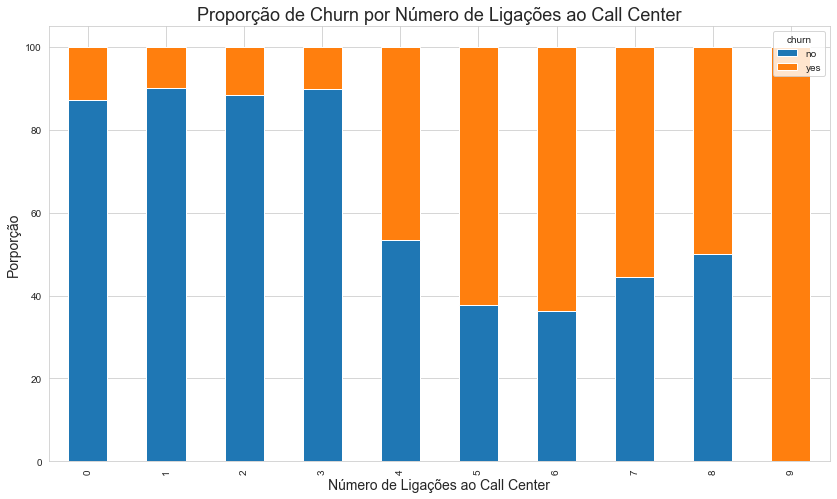

In [105]:

ax = df_aux_pivot.plot(kind='bar', stacked=True, figsize=(14,8))
set_plots_features(ax, 'Proporção de Churn por Número de Ligações ao Call Center', 'Número de Ligações ao Call Center', 'Porporção')

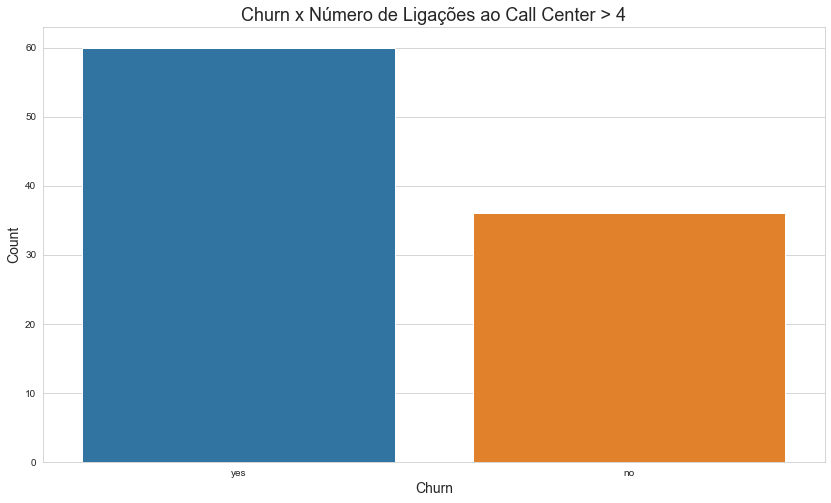

In [106]:

fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)


# Count Plot
ax = sns.countplot(x = 'churn', data=df_aux_customers)
set_plots_features(ax, 'Churn x Número de Ligações ao Call Center > 4', 'Churn', 'Count')

**H10**: Customers with a profile of talking longer during the day are more likely to leave the operator;

**TRUTH**: The churn rate of clients with a "day" profile is higher than the others. 

In [107]:
def classify_profile(day_min, eve_min, night_min):
    if (day_min > eve_min) and (day_min > night_min):
        return "day"
    elif (eve_min > day_min) and (eve_min > night_min):
        return "eve"
    elif (night_min > day_min) and (night_min > eve_min):
        return "night"
    else:
        return "mixed"
        

In [108]:
train_df_pandas2["profile"] = train_df_pandas2.apply(lambda x: classify_profile(x["total_day_minutes"], x["total_eve_minutes"], x["total_night_minutes"]), axis = 1)

In [109]:
df_aux_profile = train_df_pandas2.groupby("profile")["churn"].value_counts(normalize=True)*100
df_aux_profile = df_aux_profile[df_aux_profile.index.isin(['yes'], level=1)].droplevel(level=1).reset_index()

In [110]:
df_aux_profile_minprice = train_df_pandas2.groupby("profile")["minute_price"].mean().reset_index()

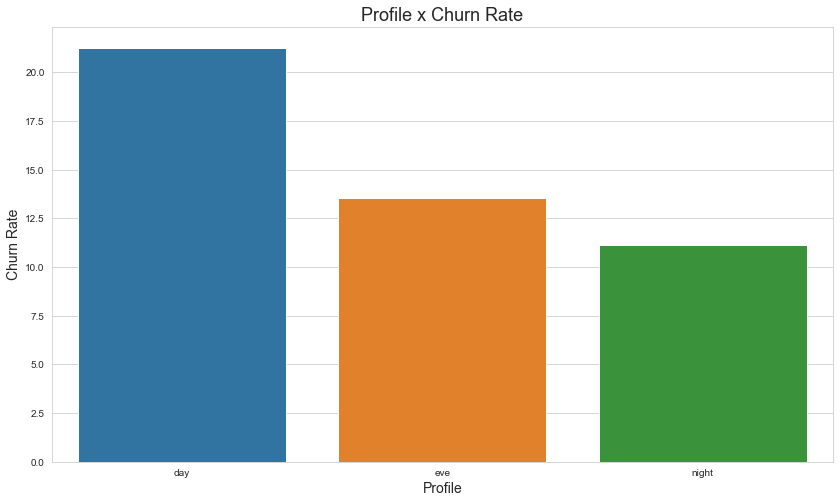

In [111]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)


# Bar Plot
ax = sns.barplot(x = 'profile', y = 'churn', data=df_aux_profile)
set_plots_features(ax, 'Profile x Churn Rate', 'Profile', 'Churn Rate')

**H11**: The price per minute for those who talk more during the day is more expensive than at night and at dawn;

**TRUTH**: The price of a minute during the day is considerably more expensive than at night and at dawn. 

In [112]:
df_aux_day = train_df_pandas2[train_df_pandas2["profile"] == "day"]

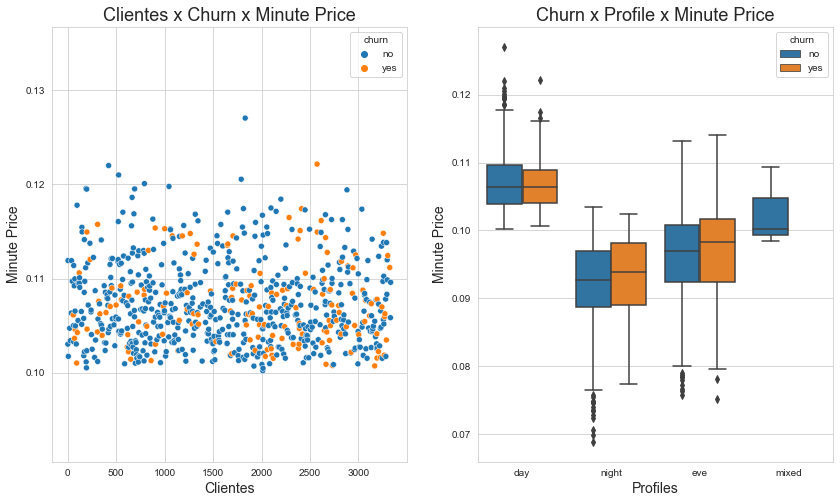

In [113]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.scatterplot(x = "id_num", hue = 'churn', y = "minute_price", data = df_aux_day)
set_plots_features(ax, "Clientes x Churn x Minute Price", "Clientes", "Minute Price")


plt.subplot(1,2,2)
ax = sns.boxplot(x = "profile", hue = 'churn', y = "minute_price", data = train_df_pandas2)
set_plots_features(ax, "Churn x Profile x Minute Price", "Profiles", "Minute Price")

**H12**: Clients who are on churn spend more during the day than at night and at dawn.

**TRUTH**: Customers who spend more during the day are at much higher risk of churn than others. 

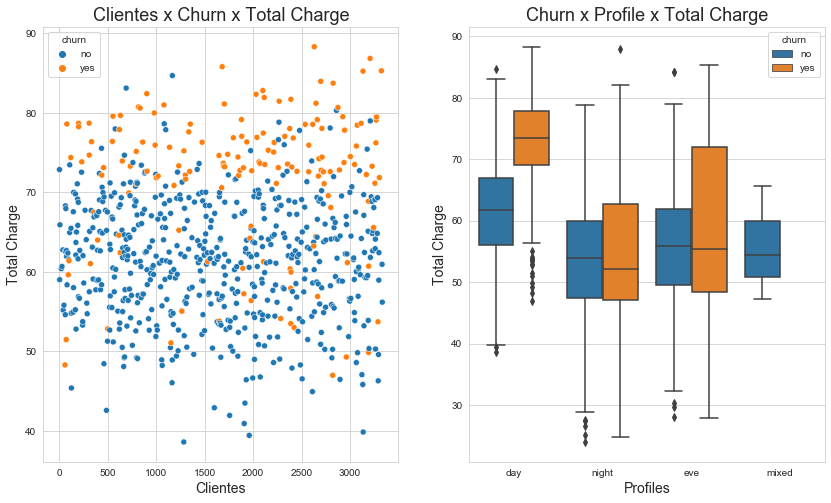

In [114]:
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(14,8)

plt.subplot(1,2,1)
ax = sns.scatterplot(x = "id_num", hue = 'churn', y = "total_charge", data = df_aux_day)
set_plots_features(ax, "Clientes x Churn x Total Charge", "Clientes", "Total Charge")


plt.subplot(1,2,2)
ax = sns.boxplot(x = "profile", hue = 'churn', y = "total_charge", data = train_df_pandas2)
set_plots_features(ax, "Churn x Profile x Total Charge", "Profiles", "Total Charge")

### 5.2.2 Resume of Hypothesis

Summarizing the assumptions initially assumed, we can see which ones are valid or not, and from that, generate insights that help the business to reduce the churn rate, through targeted promotions or find a more favorable group to cancel the operator's plan. 

In [123]:
ids = ["H1", "H2", "H3", "H4", "H5", "H6", "H7","H8", "H9", "H10", "H11", "H12"]
desc = ["Those who have an international plan are at greater risk of abandoning the operator", 
        "Whoever has a mailbox has less risk of abandoning the operator",
        "States with more immigrants are at greater risk of abandoning the operator",
        "Customers with higher churn risk speak less than those with less risk, on average",
        "Whoever is a customer for more than 100 days has less risk of leaving the operator",
        "People who are in churn have a higher minute price than those who are not",
        "Those who have an international plan and use little are more likely to abandon the operator",
        "Those who have an international plan pay less than those who don't, and consequently, have less risk of leaving the operator",
        "Those who call the call center more often have more churn risks",
        "Customers with a profile of talking longer during the day are more likely to leave the operator",
        "The price of a minute during the day is more expensive than at night and at dawn",
        "Clients who are on churn spend more during the day than at night and at dawn"]


status = ["Truth", "Truth", "Truth", "False", "Truth", "False", "Truth", "False", "Truth", "Truth", "Truth", "Truth"] 


pd.DataFrame({"Hipótese" : ids,
              "Descrição" : desc,
              "Status" : status}).set_index("Hipótese")

,Descrição,Status
Hipótese,,
H1,Those who have an international plan are at gr...,Truth
H2,Whoever has a mailbox has less risk of abandon...,Truth
H3,States with more immigrants are at greater ris...,Truth
H4,Customers with higher churn risk speak less th...,False
H5,Whoever is a customer for more than 100 days h...,Truth
H6,People who are in churn have a higher minute p...,False
H7,Those who have an international plan and use l...,Truth
H8,Those who have an international plan pay less ...,False
H9,Those who call the call center more often have...,Truth


## 5.3 Multivariate Analysis

### 5.3.1 Numerical Variables

**Correlation matrix calculation** 

C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


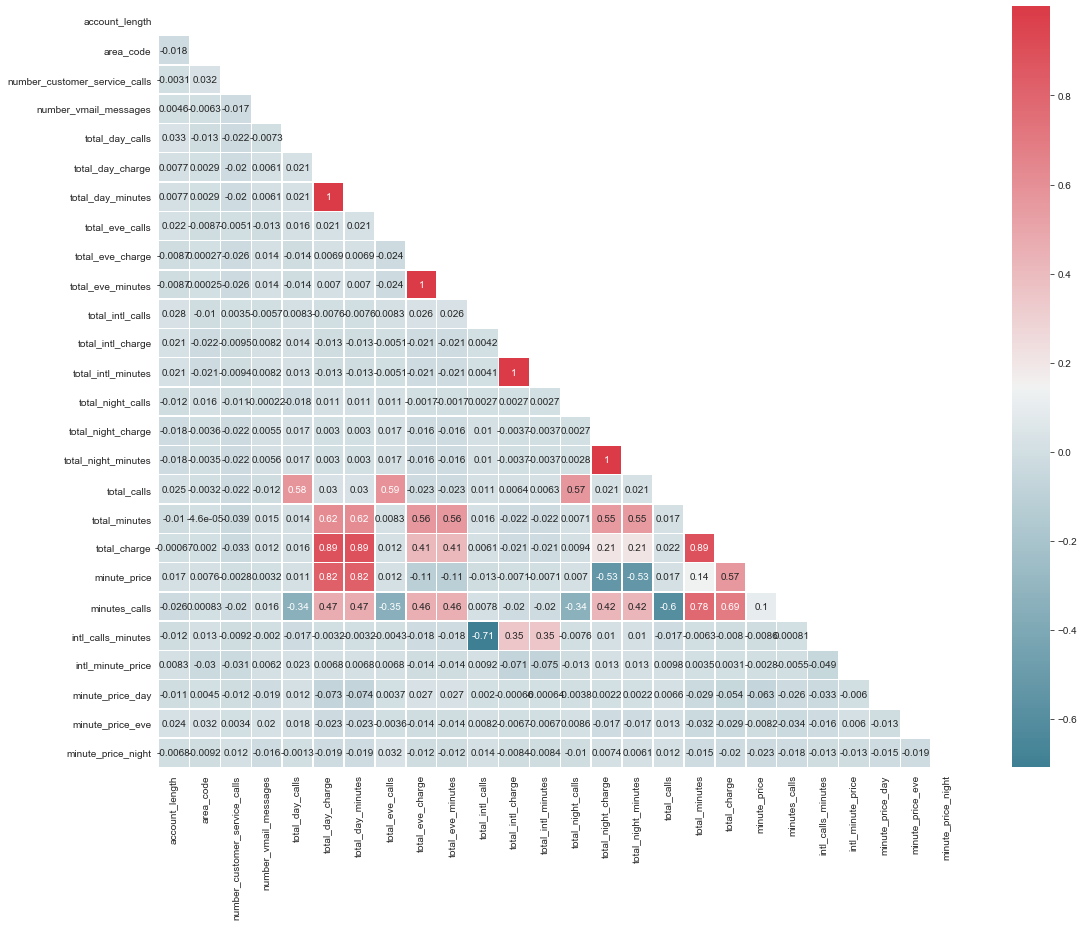

In [124]:
# Calculate the correlations
correlations = train_df_pandas2[numerical_var + ["total_calls", "total_minutes", "total_charge", "minute_price", "minutes_calls", "intl_calls_minutes", "intl_minute_price", "minute_price_day", "minute_price_eve", "minute_price_night"]].corr(method='pearson')

# Uses the variable ax for single a Axes
fig, ax = plt.subplots()

# Figure Size
ax.figure.set_size_inches(18,14)

# Gera uma mascara para o triângulo superior
mask = np.triu(np.ones_like(correlations, dtype=np.bool))

# Gera um colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plots the heatmap
sns.heatmap(correlations, cmap=cmap, mask=mask, linewidths=0.5, annot=True)



In [125]:
corr_unstacked = correlations.abs().unstack()
top_correlations = corr_unstacked.sort_values(kind="quicksort", ascending = False)

In [126]:
pair_corr = pd.DataFrame(top_correlations).reset_index().rename(columns={"level_0": "var1", "level_1": "var2", 0:"corr"})

In [127]:
duplicates_idx = []
for idx in range(len(pair_corr)-1):
    if pair_corr["var1"][idx] == pair_corr["var2"][idx]:
        duplicates_idx.append(idx)

In [128]:
pair_corr.drop(pair_corr.index[duplicates_idx], inplace = True)

In [129]:
pair_corr = pair_corr.drop_duplicates(subset='corr', keep="last")

In [130]:
pair_corr[pair_corr["corr"] < 0.99]

,var1,var2,corr
35,total_minutes,total_charge,0.892437
37,total_charge,total_day_charge,0.888110
39,total_day_minutes,total_charge,0.888108
41,minute_price,total_day_charge,0.820669
43,minute_price,total_day_minutes,0.820667
45,total_minutes,minutes_calls,0.780175
47,total_intl_calls,intl_calls_minutes,0.708616
49,total_charge,minutes_calls,0.693371
51,total_minutes,total_day_charge,0.615391
53,total_day_minutes,total_minutes,0.615389


**Observations**:

The most relevant correlations were:
- total_minutes and total_charge: 0.892
- total_charge and total_day_charge: 0.888
- total_charge and total_day_minutes: 0.888
- total_day_charge and minute_price: 0.820
- total_day_minutes and minute_calls: 0.780


It is possible to see that many variables are correlated as they are dependent on each other. In addition, it is clear that the actions on the day are the ones that most influence the "charge" or the price of the called minute. 

## 6.0 Data Preparation 

To use a machine learning model, it is important that all columns are represented as numbers to facilitate the use of mathematical expressions, except in cases where the model is able to understand strings, etc. For this, we have categorical encoding and normalization/standardization techniques for numerical values, as this helps the model by leaving the data at the same scale. 

### 6.1 Converting Categorical to Numeric Values 

In [131]:
trainDF3 = spSession.createDataFrame(train_df_pandas2)

In [132]:
trainDF4 = convert_numerical(trainDF3)

In [133]:
train_df_pandas3 = trainDF4.toPandas()

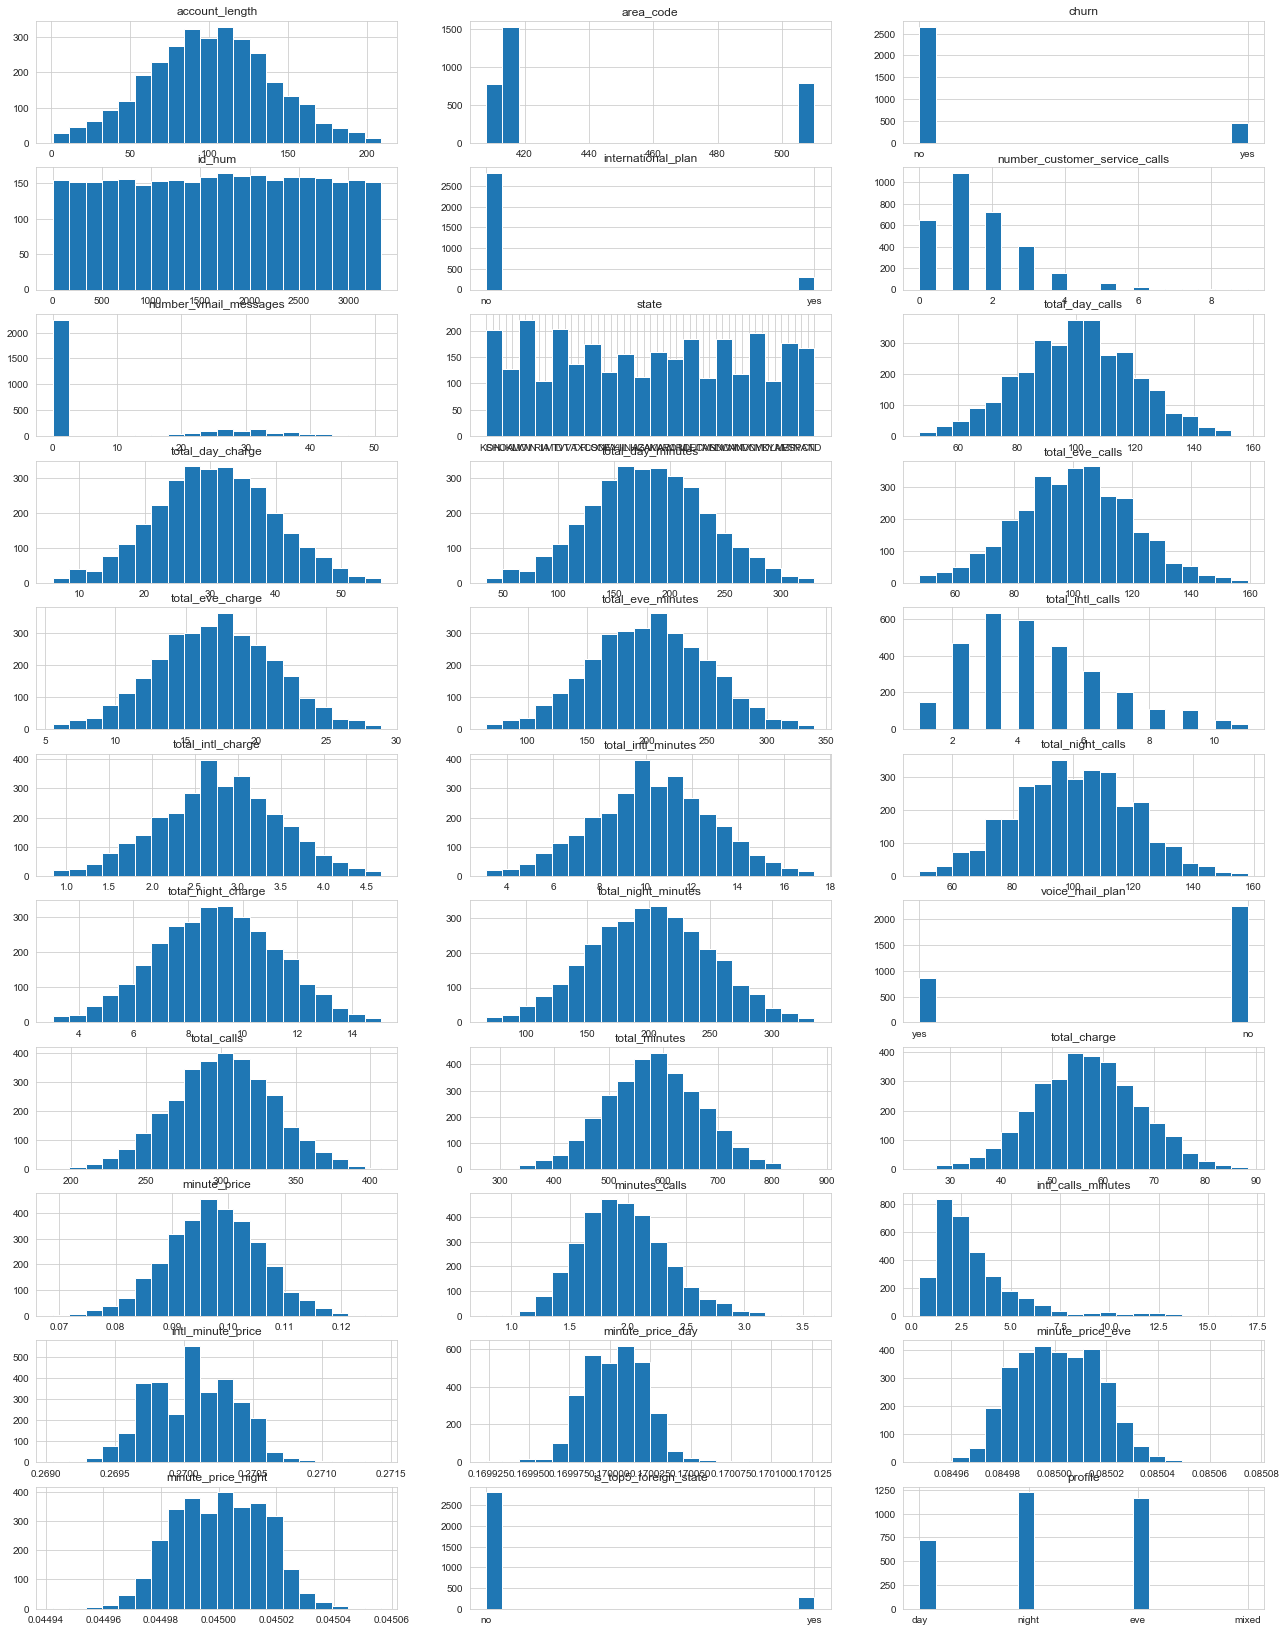

In [134]:
figure, ax = plt.subplots(figsize=(22,40))

n = 1

# Cria um histograma para cada coluna
for col in train_df_pandas2.columns:
    plt.subplot(15, 3, n)
    train_df_pandas2[col].hist(bins = 20)
    plt.title(col)
    n = n+1
    

**Variables to normalize:**

- total_day_calls
- number_vmail_messages
- total_intl_calls
- minute_calls
- intl_calls_minutes

**Variables to standardize:**
- account_length 
- total_day_calls
- total_day_charge
- total_day_minutes 
- total_eve_calls
- total_eve_charge 
- total_eve_minutes
- total_intl_charge 
- total_intl_minutes 
- total_night_calls 
- total_night_charge
- total_night_minutes
- total_calls 
- total_minutes 
- total_charge
- minute_price
- intl_minute_price
- minute_price_day
- minute_price_eve
- minute_price_night

### 6.2 Normalization

Data normalization is applied to numerical variables that preferably do not have a normal distribution. 

In [135]:
norm_var = ["total_day_calls", "number_vmail_messages", "total_intl_calls", "minutes_calls", "intl_calls_minutes"]

In [136]:
minmax_scaler = MinMaxScaler()

In [137]:
train_df_pandas3[norm_var] = minmax_scaler.fit_transform(train_df_pandas3[norm_var])

### 6.3 Standardization

The standardization of variables that are already normally distributed is applied, thus transforming them with mean 0 and std 1. 

In [138]:
stand_var = ["account_length", "total_day_calls", "total_day_charge", "total_day_minutes", "total_eve_calls", "total_eve_charge", "total_eve_minutes","total_intl_charge", "total_intl_minutes", "total_night_calls", "total_night_charge","total_night_minutes", "total_calls", "total_minutes", "total_charge", "minute_price", "intl_minute_price", "minute_price_day", "minute_price_eve", "minute_price_night"]

In [139]:
standard_scaler = StandardScaler()

In [140]:
train_df_pandas3[stand_var] = standard_scaler.fit_transform(train_df_pandas3[stand_var])

### 6.4 Removing Coluna Id_num

In [141]:
train_df_pandas3 = train_df_pandas3.drop(["id_num"], axis = 1)

## 7.0 Applying Transformations to Test Data 

In [142]:
test_df_pandas = testDF.toPandas()

### 7.1 Creating the Feature Engineering Section Variables 

In [143]:
test_df_pandas["total_calls"] = test_df_pandas["total_day_calls"] + test_df_pandas["total_eve_calls"] + test_df_pandas["total_night_calls"] 

In [144]:
test_df_pandas["total_minutes"] = test_df_pandas["total_day_minutes"] + test_df_pandas["total_eve_minutes"] + test_df_pandas["total_night_minutes"] 

In [145]:
test_df_pandas["total_charge"] = test_df_pandas["total_day_charge"] + test_df_pandas["total_eve_charge"] + test_df_pandas["total_night_charge"] 

In [146]:
test_df_pandas["minute_price"] = test_df_pandas["total_charge"] / test_df_pandas["total_minutes"] # Quanto ela gasta por minuto

In [147]:
test_df_pandas["minutes_calls"] = test_df_pandas["total_minutes"] / test_df_pandas["total_calls"] # Quanto ela fala por chamada

In [148]:
test_df_pandas["intl_calls_minutes"] = test_df_pandas["total_intl_minutes"] / test_df_pandas["total_intl_calls"] # Quanto ela fala por chamada internacional

In [149]:
test_df_pandas["intl_minute_price"] = test_df_pandas["total_intl_charge"] / test_df_pandas["total_intl_minutes"] # Quanto ela gasta por minuto

In [150]:
test_df_pandas["is_top5_foreign_state"] = test_df_pandas["state"].apply(lambda state: "yes" if state in top5_foreign_states else "no")

In [151]:
test_df_pandas["minute_price_day"] = test_df_pandas["total_day_charge"] / test_df_pandas["total_day_minutes"] # Quanto ela gasta por minuto

In [152]:
test_df_pandas["minute_price_eve"] = test_df_pandas["total_eve_charge"] / test_df_pandas["total_eve_minutes"] # Quanto ela gasta por minuto

In [153]:
test_df_pandas["minute_price_night"] = test_df_pandas["total_night_charge"] / test_df_pandas["total_night_minutes"] # Quanto ela gasta por minuto

In [154]:
test_df_pandas["profile"] = test_df_pandas.apply(lambda x: classify_profile(x["total_day_minutes"], x["total_eve_minutes"], x["total_night_minutes"]), axis = 1)

### 7.2 Normalizing and Standardizing variables 

In [155]:
testDF2 = spSession.createDataFrame(test_df_pandas)

In [156]:
testDF3 = convert_numerical(testDF2)

In [157]:
test_df_pandas2 = testDF3.toPandas()

In [158]:
test_df_pandas2[stand_var] = standard_scaler.transform(test_df_pandas2[stand_var])

In [159]:
test_df_pandas2[norm_var] = minmax_scaler.transform(test_df_pandas2[norm_var])

### 7.3 Removing the Id_Num Column 

In [160]:
test_df_pandas2 = test_df_pandas2.drop(["id_num"], axis = 1)

In [161]:
train_df_pandas3.shape

(3106, 32)

## 8.0 Feature Selection

As the model contains 34 variables, to make the models easier to use and save time, we will choose the variables in 2 different ways for comparison:

- Feature Importance with RandomForest
- PCA 

### 8.1 Creating a Label Point (Target, Features) 


**8.1.1 Training Data** 

In [162]:
trainRDD4 = spSession.createDataFrame(train_df_pandas3).rdd.map(transformVar)

In [163]:
train_all = spSession.createDataFrame(trainRDD4,["label", "features"])
train_all.select("features", "label").show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.70083788782006...|    0|
|[0.16391765066727...|    0|
|[0.93094656088554...|    0|
|[-0.6542465202322...|    0|
|[0.44516158441397...|    0|
|[1.18662286429163...|    0|
|[1.03321708224797...|    0|
|[-0.9099228236383...|    1|
|[-0.6798141505728...|    0|
|[1.72354310144442...|    0|
+--------------------+-----+
only showing top 10 rows



**8.1.2 Test Data** 

In [164]:
testRDD4 = spSession.createDataFrame(test_df_pandas2).rdd.map(transformVar)

In [165]:
test_all = spSession.createDataFrame(testRDD4,["label", "features"])
test_all.select("features", "label").show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.01051186862361...|    0|
|[0.93094656088554...|    0|
|[0.06164712930483...|    0|
|[-0.0406233920575...|    0|
|[0.18948528100788...|    0|
|[0.41959395407336...|    0|
|[-0.9610580843195...|    0|
|[-0.1684615437606...|    0|
|[0.95651419122615...|    0|
|[0.70083788782006...|    0|
+--------------------+-----+
only showing top 10 rows



### 8.1 Feature Importances 

In [166]:
rf = RandomForestClassifier()
model = rf.fit(train_all)
print(model.featureImportances)

(31,[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],[0.005398031633849266,0.11224804899909198,0.11293633749110857,0.05243259313979586,0.007737918546096091,0.13167614661498697,0.06580718202000675,0.002655019822369258,0.015151442441234295,0.015874900999823575,0.04030179216760627,0.01538359513864285,0.03322344936116523,0.004789868337058519,0.006180216700201795,0.0016971040616914634,0.04362272362547803,0.004820665690132987,0.06857979873672153,0.17194795398880391,0.013228239722343053,0.021415500671213786,0.030573996777480534,0.009680725396536017,0.0004114521000531021,0.0039435316369528985,0.0006535606933271876,0.0027604620596165066,0.0010288214498116387,0.003838919976799938])


In [167]:
features_imp = model.featureImportances.toArray()
feature_names = train_df_pandas3.columns
feature_names = feature_names.drop("churn")

In [168]:
len(features_imp)

31

In [169]:
features = pd.DataFrame({"feature_names": feature_names,
             "features_imp": features_imp}).sort_values("features_imp", ascending = False)

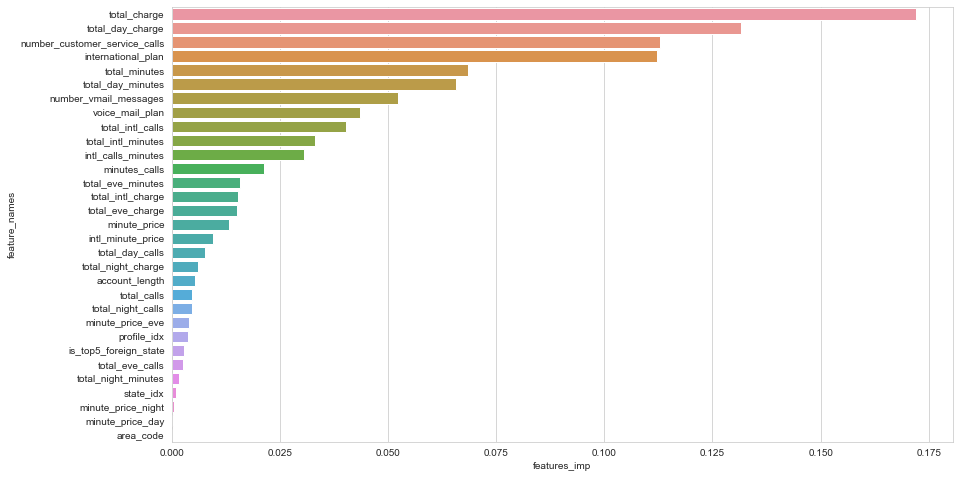

In [170]:
plt.figure(1, figsize=(14,8))
sns.barplot(x = "features_imp", y = "feature_names", data=features, orient = 'h')

From the feature importances model generated by Random Forest, we can select the variables that most impact the model. With that, the selected variables are:

- total_charge
- total_day_charge
- number_customer_service_calls
- international_plan
- total_day_minutes
- total_minutes
- number_vmail_messages
- voice_mail_plan
- intl_calls_minutes
- total_intl_minutes
- minutes_calls
- minute_price 

In [171]:
trainRDD5 = spSession.createDataFrame(train_df_pandas3).rdd.map(transform_selected_vars)

In [172]:
train_selected = spSession.createDataFrame(trainRDD5,["label", "features"])
train_selected.select("features", "label").show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.57622796573144...|    0|
|[-0.1251315134721...|    0|
|[0.21474745870130...|    0|
|[-0.7321985793773...|    0|
|[0.89352309388011...|    0|
|[-1.1624499950189...|    0|
|[2.03398403808068...|    0|
|[-0.5936929866708...|    1|
|[-0.2155039569402...|    0|
|[-1.9296334553295...|    0|
+--------------------+-----+
only showing top 10 rows



In [173]:
testRDD5 = spSession.createDataFrame(test_df_pandas2).rdd.map(transform_selected_vars)

In [174]:
test_selected = spSession.createDataFrame(testRDD5,["label", "features"])
test_selected.select("features", "label").show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-1.5848429373154...|    0|
|[0.61356498096266...|    0|
|[2.64890957733095...|    0|
|[0.07034801098598...|    0|
|[-0.3451687671336...|    0|
|[0.37093461643420...|    0|
|[1.01434712156027...|    0|
|[0.29824373799247...|    0|
|[-2.1919100032206...|    0|
|[-0.5229667265653...|    0|
+--------------------+-----+
only showing top 10 rows



### 8.2 PCA

In [175]:
# Applying dimension reduction with PCA
PCA_obj = PCA(k = 8, inputCol = "features", outputCol = "pcaFeatures")
pcaModel = PCA_obj.fit(train_all)
train_PCA = pcaModel.transform(train_all).select("label","pcaFeatures")


In [176]:
test_PCA = pcaModel.transform(test_all).select("label","pcaFeatures")

## 9.0 Machine Learning models

In the models step, we will cover 3 types of models using Pyspark's MLLib library. The models chosen were:

- Logistic Regression
- Naive Bayes
- Random Forest 

In [177]:
# Allocating all dataframes to memory
train_all.cache()
test_all.cache()
train_selected.cache()
test_selected.cache()
train_PCA.cache()
test_PCA.cache()

DataFrame[label: bigint, pcaFeatures: vector]

### 9.1 Logistic Regression 

In [181]:
# Logistic Regression
lr_all = LogisticRegression(labelCol="label", featuresCol="features")
model_all = lr_all.fit(train_all)

# Predictions
predictions = model_all.transform(test_all)
predictions.select("prediction", "label", "features").first()

# Evaluation
acc = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
prec = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "weightedPrecision")
print("Accuracy nos dados de teste com todas as variáveis:", acc.evaluate(predictions))
print("Precision nos dados de teste com todas as variáveis:", prec.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com todas as variáveis: 0.8782243551289742
Precision nos dados de teste com todas as variáveis: 0.85880708989653
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  153|
|    0|       1.0|   50|
|    0|       0.0| 1393|
|    1|       1.0|   71|
+-----+----------+-----+



In [182]:
# Logistic Regression
lr_sel = LogisticRegression(labelCol="label", featuresCol="features")
model_sel = lr_sel.fit(train_selected)

# Predictions
predictions = model_sel.transform(test_selected)
predictions.select("prediction", "label", "features").first()

#Evaluation
acc = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
prec = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "weightedPrecision")
print("Accuracy nos dados de teste com as melhores 12 variáveis:", acc.evaluate(predictions))
print("Precision nos dados de teste com as melhores 12 variáveis:", prec.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com as melhores 12 variáveis: 0.877624475104979
Precision nos dados de teste com as melhores 12 variáveis: 0.8558293302812845
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  163|
|    0|       1.0|   41|
|    0|       0.0| 1402|
|    1|       1.0|   61|
+-----+----------+-----+



In [183]:
# Logistic Regression
lr_PCA = LogisticRegression(labelCol="label", featuresCol="pcaFeatures")
model_PCA = lr_PCA.fit(train_PCA)

# Predictions
predictions = model_PCA.transform(test_PCA)
predictions.select("prediction", "label", "pcaFeatures").first()

# Evaluation
acc = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
prec = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "weightedPrecision")
print("Accuracy nos dados de teste com PCA:", acc.evaluate(predictions))
print("Precision nos dados de teste com PCA:", prec.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com PCA: 0.8650269946010798
Precision nos dados de teste com PCA: 0.8215993412161541
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  206|
|    0|       1.0|   19|
|    0|       0.0| 1424|
|    1|       1.0|   18|
+-----+----------+-----+



Using the Logistic Regression algorithm, the best result presented is with all variables, however, it is possible to reduce the complexity of the model using only 12, since the precision difference is very low. 

### 9.2 Decision Tree

In [184]:
# Decision Tree
dt_all = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model_all = dt_all.fit(train_all)

# Predictions
predictions = model_all.transform(test_all)
predictions.select("prediction", "label", "features").first()


acc = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
prec = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "weightedPrecision")
print("Accuracy nos dados de teste com todas as variáveis:", acc.evaluate(predictions))
print("Precision nos dados de teste com todas as variáveis:", prec.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com todas as variáveis: 0.9652069586082783
Precision nos dados de teste com todas as variáveis: 0.9646296540182706
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   47|
|    0|       1.0|   11|
|    0|       0.0| 1432|
|    1|       1.0|  177|
+-----+----------+-----+



In [185]:
# Decision Tree
dt_sel = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model_sel = dt_sel.fit(train_selected)

# Predictions
predictions = model_sel.transform(test_selected)
predictions.select("prediction", "label", "features").first()


acc = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
prec = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "weightedPrecision")
print("Accuracy nos dados de teste com as melhores 12 variáveis:", acc.evaluate(predictions))
print("Precision nos dados de teste com as melhores 12 variáveis:", prec.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com as melhores 12 variáveis: 0.9664067186562687
Precision nos dados de teste com as melhores 12 variáveis: 0.965847308035453
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   45|
|    0|       1.0|   11|
|    0|       0.0| 1432|
|    1|       1.0|  179|
+-----+----------+-----+



In [186]:
# Decision Tree
dt_PCA = DecisionTreeClassifier(labelCol="label", featuresCol="pcaFeatures")
model_PCA = dt_PCA.fit(train_PCA)

# Predictions
predictions = model_PCA.transform(test_PCA)
predictions.select("prediction", "label", "pcaFeatures").first()

# Evaluation
acc = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
prec = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "weightedPrecision")
print("Accuracy nos dados de teste com PCA:", acc.evaluate(predictions))
print("Precision nos dados de teste com PCA:", prec.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com PCA: 0.9190161967606478
Precision nos dados de teste com PCA: 0.9130005415797929
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  101|
|    0|       1.0|   34|
|    0|       0.0| 1409|
|    1|       1.0|  123|
+-----+----------+-----+



As noted above, using a decision tree algorithm, the accuracy of the model increases considerably, with the model with the best 12 variables showing the best performance. 

### 9.3 Random Forest

In [187]:
# Random Forest
rf_all = RandomForestClassifier(labelCol="label", featuresCol="features")
model_all = rf_all.fit(train_all)

# Predictions
predictions = model_all.transform(test_all)
predictions.select("prediction", "label", "features").first()

# Evaluation
acc = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
prec = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "weightedPrecision")
print("Accuracy nos dados de teste com todas as variáveis:", acc.evaluate(predictions))
print("Precision nos dados de teste com todas as variáveis:", prec.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com todas as variáveis: 0.9424115176964607
Precision nos dados de teste com todas as variáveis: 0.9440310808242164
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   92|
|    0|       1.0|    4|
|    0|       0.0| 1439|
|    1|       1.0|  132|
+-----+----------+-----+



In [188]:
# Random Forest
rf_sel = RandomForestClassifier(labelCol="label", featuresCol="features")
model_sel = rf_sel.fit(train_selected)

# Predictions
predictions = model_sel.transform(test_selected)
predictions.select("prediction", "label", "features").first()

# Evaluation
acc = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
prec = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "weightedPrecision")
print("Accuracy nos dados de teste com as melhores 12 variáveis:", acc.evaluate(predictions))
print("Precision nos dados de teste com as melhores 12 variáveis:", prec.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com as melhores 12 variáveis: 0.9448110377924415
Precision nos dados de teste com as melhores 12 variáveis: 0.945182512496447
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   85|
|    0|       1.0|    7|
|    0|       0.0| 1436|
|    1|       1.0|  139|
+-----+----------+-----+



In [189]:
# Random Forest
rf_PCA = RandomForestClassifier(labelCol="label", featuresCol="pcaFeatures")
model_PCA = rf_PCA.fit(train_PCA)

# Predictions
predictions = model_PCA.transform(test_PCA)
predictions.select("prediction", "label", "pcaFeatures").first()

# Evaluation
acc = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "accuracy")
prec = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label", metricName = "weightedPrecision")
print("Accuracy nos dados de teste com PCA:", acc.evaluate(predictions))
print("Precision nos dados de teste com PCA:", prec.evaluate(predictions))
# Confusion Matrix
predictions.groupBy("label", "prediction").count().show()

Accuracy nos dados de teste com PCA: 0.9196160767846431
Precision nos dados de teste com PCA: 0.9156430881247503
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  116|
|    0|       1.0|   18|
|    0|       0.0| 1425|
|    1|       1.0|  108|
+-----+----------+-----+



The best performance of the ensemble model with different variable selection/dimensionality reduction techniques was also using the 12 best variables. 

## 10.0 Hyperparameters Fine-Tuning

As the model that presented the best result was the Decision Tree with the best 12 variables chosen through Feature Importance, the penultimate stage of the project is to try to take this model and perform a hyperparameter tuning, in order to obtain the best possible accuracy. 

In [190]:
# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()
               .addGrid(dt_sel.maxDepth, [2, 5, 10])
               .addGrid(dt_sel.maxBins, [5, 10, 20])
               .addGrid(dt_sel.minInstancesPerNode, [2, 4, 8])
             .build())

In [194]:
evaluator_cv = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "label")
# Create 5-fold CrossValidator
dtcv = CrossValidator(estimator = dt_sel,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = evaluator_cv,
                      numFolds = 5)

In [195]:
dtcvModel = dtcv.fit(train_selected)

In [196]:
print(dtcvModel)

CrossValidatorModel_d6bd283137e8


In [197]:
dtpredictions = dtcvModel.transform(test_selected)

In [207]:
evaluator_cv.setMetricName("accuracy")

MulticlassClassificationEvaluator_7d3ac18038fe

In [212]:
# Evaluates the best model
print('Accuracy:', evaluator_cv.setMetricName("accuracy").evaluate(dtpredictions))
print('Precision:', evaluator_cv.setMetricName("weightedPrecision").evaluate(dtpredictions))
dtpredictions.groupBy("label", "prediction").count().show()

Accuracy: 0.9598080383923215
Precision: 0.958695373600372
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   46|
|    0|       1.0|   21|
|    0|       0.0| 1422|
|    1|       1.0|  178|
+-----+----------+-----+



The best accuracy of the model was without hyperparameter tuning. 

## 11.0 Project Resume

At the end of the project, everything requested by the company's CEO is summarized:

- What is the Churn Rate of the Operator today?

**Answer:** Around 14%.

- How does the model perform when classifying customers in Churn?

**Answer:** The performance of the best model (Decision Tree with 12 variables) was 95.98% accuracy and 95.86% weighted precision. 

In addition, we were able to identify that:

- Those who have an international plan and enjoy very little of it, are more likely to leave the operator;
- Those who complain more than 4 times to the call center have a high probability of churn;
- States with more immigrants tend to have a plan cancellation;
- New customers (less than 100 days of relationship) are more likely to churn;
- States like California, New Jersey, Texas, among others, have a very high Churn Rate, requiring a special look.
- The price of the minute of the day is more expensive than the night and the dawn. It was also found that people who are on churn talk more during the day, which leads to higher charges, probably influencing the non-renewal of the plan. 